In [1]:
# ====================================================================   imporing Libraries  ========================================================================= #

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from numpy.random import normal, rand, randint
from tqdm import tqdm
import matplotlib.pyplot as plt
from numpy.random import Generator, SFC64
from dataclasses import dataclass, field
from typing import Dict, List
import os
import random
import copy
import math


In [2]:
# =================================================================================================================================================================== #
# ====================================================================   imporing profiles data  ==================================================================== #
# =================================================================================================================================================================== #

# ===============================================   Importing profiles of appliance use (input for section 1.3)  ==================================================================

file_path_appliance = r'\\file\Usersa$\aka279\Home\Desktop\Baxter\Model - 250709\Appliance profiles.xlsx' 
profiles_df = pd.read_excel(file_path_appliance, header=None)

# =============================================   Importing DHW demand profiles (input for section 1.6)  ==================================================================

base_path_DHW =  r'\\file\Usersa$\aka279\Home\Desktop\Baxter\Model - 250709'

filenames = {
    'dm_DHW_050': 'dm_050.xlsx',
    'dm_DHW_100': 'dm_100.xlsx',
    'dm_DHW_150': 'dm_150.xlsx',
    'dm_DHW_200': 'dm_200.xlsx',
    'dm_DHW_250': 'dm_250.xlsx'
}

# ================================================ Importing climate data  (input for section 1.7) =========================================================================

base_path_climate = r'\\file\Usersa$\aka279\Home\Desktop\Baxter\Model - 250709'

Starting 1 simulations across 1 cases...
Cities: [1]
Deciles: [1]
Months: [1]
Cases: [1]

SIMULATION 1/1
Case 1: Baseline
City: Auckland | Decile: 1 | Month: Jan
Progress: 100.0%
Case Configuration:
  - Appliance efficiency: 1.0x
  - LED proportion: 14%
  - Insulation increase: 0 Wm⁻²K⁻¹
  - Electric heaters: 30%
  - Heat pumps: 19%
Starting simulation...

Progress: 0.0%
Progress: 20.0%
Progress: 40.0%
Progress: 60.0%
Progress: 80.0%

Total demand:       2288.3 kWh
     EV charging:   0.0 kWh (0.0 %)
     Appliances:    124.2 kWh (5.4 %)
     HWC:           633.5 kWh (27.7 %)
     Space heating: 33.6 kWh (1.5 %)
     Refrigeration: 528.7 kWh (23.1 %)
     Baseline:      493.6 kWh (21.6 %)
     Lighting:      474.8 kWh (20.7 %)

Equivalent annual demand per house: 5568.3 kWh
     EV charging:   0.0 kWh
     Appliances:    302.2 kWh
     HWC:           1541.4 kWh
     Space heating: 81.6 kWh
     Refrigeration: 1286.6 kWh
     Baseline:      1201.2 kWh
     Lighting:      1155.2 kWh

Tot

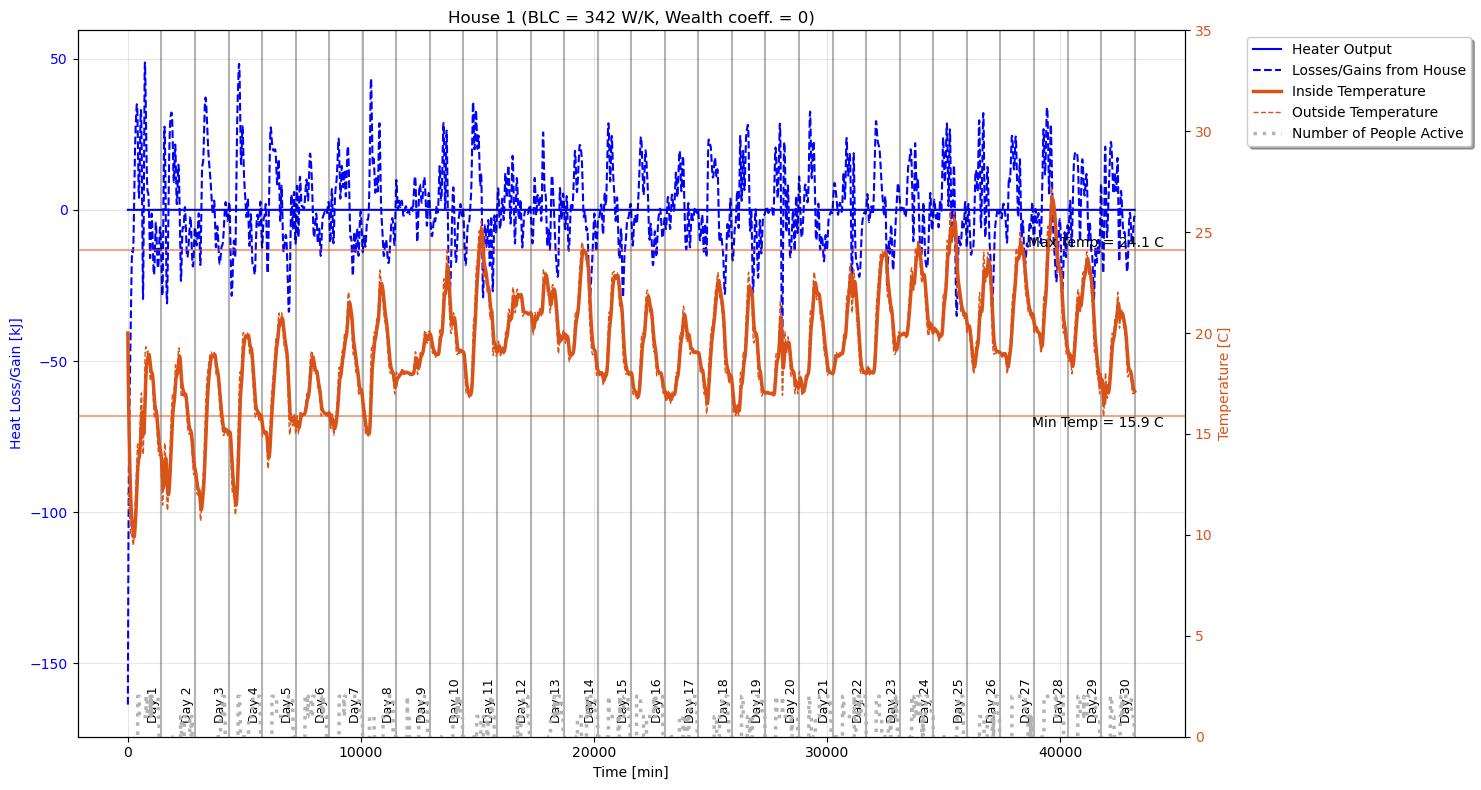

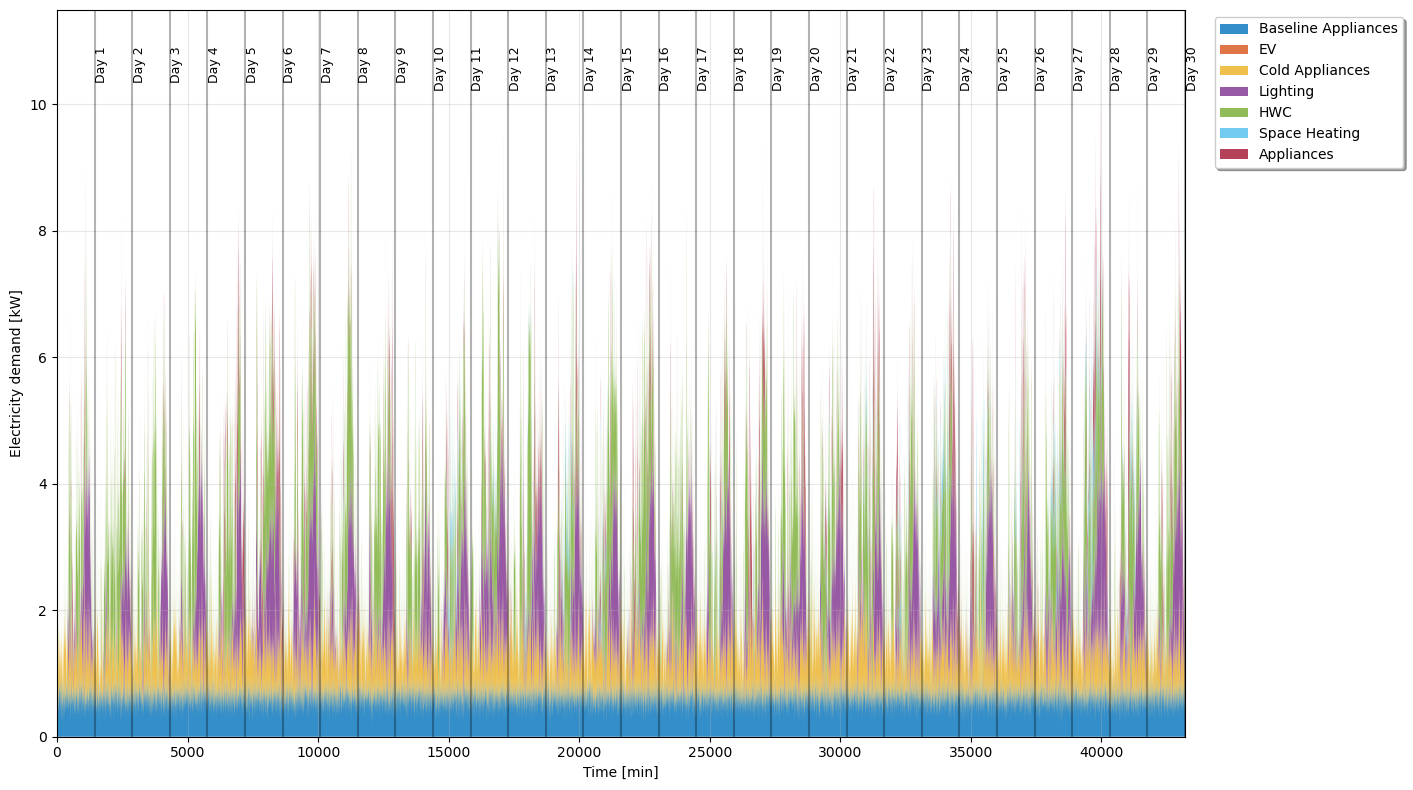

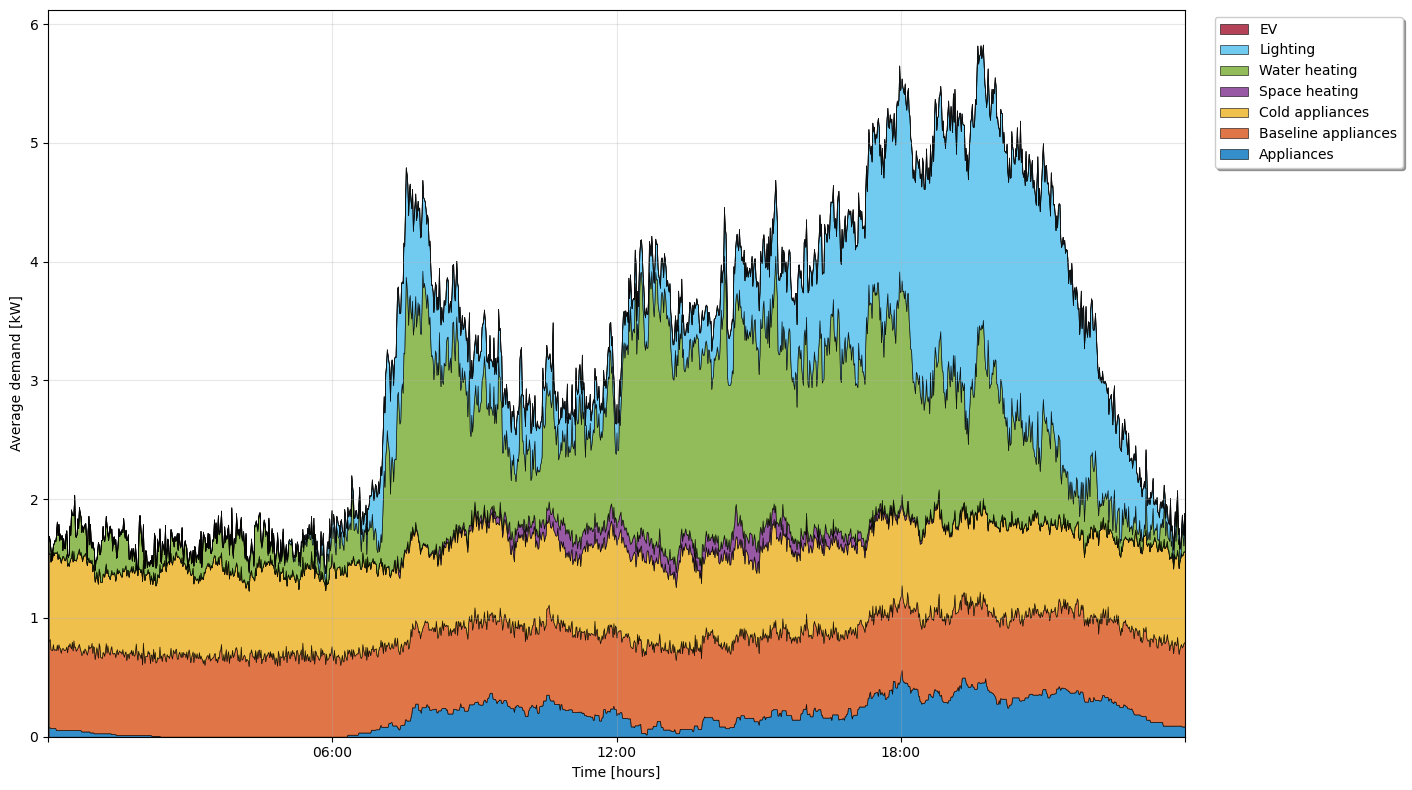

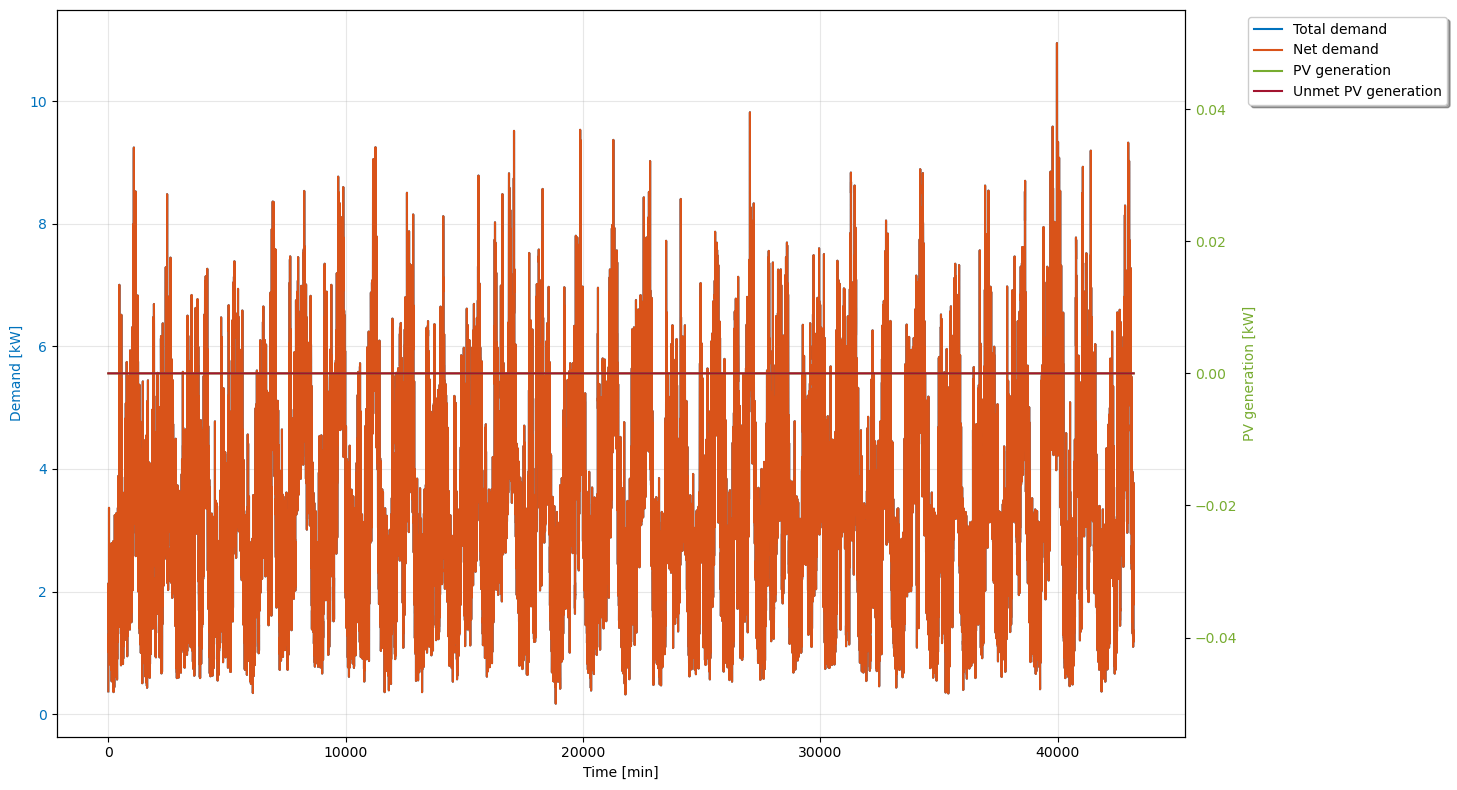


Average demand = 3.2 kW
Peak demand = 10.9 kW
Average demand with PV = 3.2 kW
Peak demand with PV = 10.9 kW
Average inside temperature = 19.1 C
Average temp with active agents = 19.8 C

Saving results with tag: Case01_Baseline_City1_Auckland_Decile01_Month01_Jan
✓ Results saved:
  - Summary metrics: summary_metrics_Case01_Baseline_City1_Auckland_Decile01_Month01_Jan.csv
  - Demand profiles: demand_avg_profiles_Case01_Baseline_City1_Auckland_Decile01_Month01_Jan.csv
  - PV data: demand_avg_PV_Case01_Baseline_City1_Auckland_Decile01_Month01_Jan.csv
  - Appliance usage: appliance_usage_Case01_Baseline_City1_Auckland_Decile01_Month01_Jan.csv

ALL SIMULATIONS COMPLETE - CREATING CONSOLIDATED RESULTS
✓ Consolidated results saved: ALL_CASES_consolidated_results_1cases_1cities_1deciles_1months.csv
✓ Total simulations: 1
✓ All files saved in: \\file\Usersa$\aka279\Home\Desktop\Baxter\LastVersion_1

SUMMARY ACROSS ALL CASES
Energy Total - Min: 2288.3, Max: 2288.3, Mean: 2288.3 kWh
Peak Demand -

In [5]:
# =================================================================================================================================================================== #
# ====================================================================   1.PRE-PROCESSING   ========================================================================= #
# =================================================================================================================================================================== #

# ==============================================   1.1. For-loop variables WITH CASE STUDIES   =========================================================================

# Define the 9 cases from the table
cases_config = {
    1: {'name': 'Baseline', 'p_appliance_scale': 1.0, 'LED_proportion': 0.14, 'insulation_increase': 0, 'prop_e_heater': 0.30, 'prop_HP': 0.19},
    2: {'name': 'Efficient_Appliances', 'p_appliance_scale': 0.5, 'LED_proportion': 0.14, 'insulation_increase': 0, 'prop_e_heater': 0.30, 'prop_HP': 0.19},
    3: {'name': 'All_LED', 'p_appliance_scale': 1.0, 'LED_proportion': 1.0, 'insulation_increase': 0, 'prop_e_heater': 0.30, 'prop_HP': 0.19},
    4: {'name': 'Insulation_Upgrade', 'p_appliance_scale': 1.0, 'LED_proportion': 0.14, 'insulation_increase': 2, 'prop_e_heater': 0.30, 'prop_HP': 0.19},
    5: {'name': 'No_Electric_Heating', 'p_appliance_scale': 1.0, 'LED_proportion': 0.14, 'insulation_increase': 0, 'prop_e_heater': 0.0, 'prop_HP': 0.0},
    6: {'name': 'All_Electric_Heaters', 'p_appliance_scale': 1.0, 'LED_proportion': 0.14, 'insulation_increase': 0, 'prop_e_heater': 1.0, 'prop_HP': 0.0},
    7: {'name': 'All_Electric_Heaters_Insulation', 'p_appliance_scale': 1.0, 'LED_proportion': 0.14, 'insulation_increase': 2, 'prop_e_heater': 1.0, 'prop_HP': 0.0},
    8: {'name': 'No_Heating', 'p_appliance_scale': 1.0, 'LED_proportion': 0.14, 'insulation_increase': 0, 'prop_e_heater': 0.0, 'prop_HP': 1.0},
    9: {'name': 'All_Heat_Pumps_Insulation', 'p_appliance_scale': 1.0, 'LED_proportion': 0.14, 'insulation_increase': 2, 'prop_e_heater': 0.0, 'prop_HP': 1.0}
}

# Set simulation parameters for all cases (set to "1" for all variable to run the first case of each parameter)
cities_run = [1]    #[1,2, 3]           # Auckland and Christchurch
deciles_run =[1]    #[1, 3, 7, 10]   # Income deciles 1, 3, 7, 10
months_run = [1]    #[1,6]           # January and June
cases_run = [1]     #list(range(1, 10)) # All 9 cases

# Initialize storage dictionary for results
simulation_results = {}

# Export directory setup
export_path = r"\\file\Usersa$\aka279\Home\Desktop\Baxter\LastVersion_1"

# City names mapping for consistent use
city_names = {1: 'Auckland', 2: 'Wellington', 3: 'Christchurch'}
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# Calculate total number of simulations
total_simulations = len(cities_run) * len(deciles_run) * len(months_run) * len(cases_run)
current_simulation = 0

print(f"Starting {total_simulations} simulations across {len(cases_run)} cases...")
print(f"Cities: {cities_run}")
print(f"Deciles: {deciles_run}") 
print(f"Months: {months_run}")
print(f"Cases: {cases_run}")

# Loop through each configuration
for case_num in cases_run:
    for city_num in range(len(cities_run)):
        for deciles_num in range(len(deciles_run)):
            for month_num in range(len(months_run)):
                
                # Reset the random number generator (for repeatable results)
                rng = Generator(SFC64(1))  # Initialize RNG with MT19937 algorithm

                current_simulation += 1
                
                city = cities_run[city_num]
                decile = deciles_run[deciles_num]
                month = months_run[month_num]
                
                # Get case configuration
                case_config = cases_config[case_num]
                
                print(f"\n{'='*80}")
                print(f"SIMULATION {current_simulation}/{total_simulations}")
                print(f"Case {case_num}: {case_config['name']}")
                print(f"City: {city_names.get(city, f'City {city}')} | Decile: {decile} | Month: {month_names.get(month, f'Month {month}')}")
                print(f"Progress: {100*current_simulation/total_simulations:.1f}%")
                print(f"{'='*80}")
                
                # Apply case-specific parameters
                p_appliance_scale = case_config['p_appliance_scale']
                insulation_increase = case_config['insulation_increase']
                prop_HP = case_config['prop_HP']
                prop_e_heater = case_config['prop_e_heater']
                LED_proportion = case_config['LED_proportion']
                
                # Update lighting proportions for LED case
                if case_num == 3:  # All LED case
                    light_prop = {'LED': 1.00, 'CFL': 0.00,'Halogen': 0.00,'Incandescent': 0.00,'Other': 0.00}
                else:
                    # Original proportions for other cases
                    light_prop = {'LED': 0.14,'CFL': 0.28,'Halogen': 0.21,'Incandescent': 0.34,'Other': 0.03
                    }
                
                # Update heating proportions
                prop_HP = case_config['prop_HP']
                prop_e_heater = case_config['prop_e_heater']
                
                # Create unique key for this configuration
                config_key = f"Case_{case_num}_City_{city}_Decile_{decile}_Month_{month}"
                
                print(f"Case Configuration:")
                print(f"  - Appliance efficiency: {p_appliance_scale:.1f}x")
                print(f"  - LED proportion: {case_config['LED_proportion']*100:.0f}%")
                print(f"  - Insulation increase: {insulation_increase} Wm⁻²K⁻¹")
                print(f"  - Electric heaters: {prop_e_heater*100:.0f}%")
                print(f"  - Heat pumps: {prop_HP*100:.0f}%")
                print(f"Starting simulation...\n")
                
                # =================================================   1.2. Initial Variables   ======================================================================
                
                # Simulation length
                N_days = 30
                start_day_week = 1
                
                # Time of year
                #month = 1              # Have been defined as a loop
                year = 2023
                
                # Neighbourhood variables
                # city = 3  # 1 = Auckland, 2 = Wellington, 3 = Christchurch      # Have been defined as a loop
                # decile = 10     # Have been defined as a loop
                
                # Average responsiveness to manual DR requests
                DR_elasticity_mu = 0.0
                DR_elasticity_sigma = 0
                
                # Proportion participating in appliance scheduling
                prop_scheduling = 0.0
                prop_HWC_DR = 0.0
                
                # Flags for the type of incentive function
                incentive_function_rtp = 0
                incentive_function_tou = 0
                
                # Peak times
                peak_1 = [7, 11]         # [hours]
                peak_2 = [17, 21]        # Peaks 7-11 and 5-9 
                
                two_peaks = 0
                peak_1_b = [8, 12]
                peak_2_b = [18, 22]
                
                # Changes in behavioural profiles at 100% elasticity
                on_peak = -1
                off_peak = +1
                
                # Insulation scaling factor
                #insulation_increase = 0                                                       # insulation_increase = case_config['insulation_increase']  # Have been defined in the "cases_run" loop
                heat_temp_increase = insulation_increase * 0.25
                scale_income = 1
                scale_HWC_insulation = 1
                
                # Changing efficiency of appliances
                #p_appliance_scale = 1.0      # <1 = decrease, >1 = increase                    # p_appliance_scale = case_config['p_appliance_scale']    # Have been defined in the "cases_run" loop
                
                # Solar panels and batteries:
                PV_size_mu = 0          # Average PV installed capacity [kW]
                PV_size_sigma = 0
                eta_PV = 0.2
                PV_area_per_kW = 4.42   # Average size of panels per kWp
                battery_size_mu = 0    # Average battery capacity [kWh]
                battery_size_sigma = 0
                battery_rate_mu = 10    # Average battery discharge rate [kW] (Tesla Powerwall = 5 kW)
                battery_rate_sigma = 0
                eta_battery = 0.9
                
                
                # Loading neighbourhood variables
                months_day = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
                start_day = months_day[month - 1]      # Day of the year (1 = 1st Jan, 182 = 1st July, 230 = 18th August)
                
                # General variables
                N_houses = 5 #50
                time = np.arange(1, 1440 * N_days + 1)                                            # N_days: 1, 2, 3, … , 1440*N_days
            
                people_per_household = 2.7          #Avg. from 2023 census
                N_people_total = round(N_houses * people_per_household)
                
                # Wealth/income variables
                income_deciles = [15000, 20000, 25000, 30000, 35000, 40000, 50000, 60000, 80000, 100000]  # From 2023 census
                avg_weekly_income = income_deciles[decile - 1] / 52
                income_annual_sd = 30000
                        # Income heating bounds (line fitted between these)
                heat_lower = 1.0    # Below this prop. of mean income, never heat if above min. Temp
                heat_upper = 2.0    # Above this prop. of mean income, always heat
                min_heat_temp = 9   # Below this temperature, everybody heats
                
                
                cars_per_capita = 0.68     # Light passenger vehicles per capita
                prop_EV = 0              # Proportion of cars that are EVs  ##My assumption
                prop_eHWC = 0.86           # Proportion of houses with eHWCs
                #prop_HP = 0.19              # Proportion of houses with heat pumps     # Have been defined in the "cases_run" loop
                #prop_e_heater = 0.30        # Proportion of houses with (non-heat-pump) electric heaters      # Have been defined in the "cases_run" loop
                prop_selfish = 1.0         # Proportion of EVs selfishly charged
                prop_WFH = 0.1             # Proportion of people staying at home                
                wakeup_wfh = 2 * 60        # Average extra sleep-in if wfh [min]
                network_rated_power = 300  # [kVA]
                demand_desired = network_rated_power / 3
                trans_rated_life = 30     # [years]
                power_factor = 1.0        # Converting to kW
                network_max_power = network_rated_power * power_factor
                climate_zone = 2
                
                # Function to change the appliance profiles according to time of year
                appliance_annual_var = lambda d: 0.6 + 0.4 * np.cos((np.pi / (365 / 2)) * d - np.pi)
                DHW_annual_var = lambda d: 1 + 0.2 * np.cos((np.pi / (365 / 2)) * d - np.pi)
                
                # Cumulative proportions for bulb selection
                light_prop_cum = {
                        'LED': light_prop['LED'],
                        'CFL': light_prop['LED'] + light_prop['CFL'],
                        'Halogen': light_prop['LED'] + light_prop['CFL'] + light_prop['Halogen'],
                        'Incandescent': light_prop['LED'] + light_prop['CFL'] + light_prop['Halogen'] + light_prop['Incandescent'],
                        'Other': 1
                    }
                
               
                bulb_per_house_mean = 23
                bulb_per_house_sd = 5
                
                # Lightbulb power [kW] (average for 700-900 lm)
                power_LED = 0.01
                power_CFL = 0.011
                power_Halogen = 0.042
                power_Incandescent = 0.06
                
                # Random variables for attributes
                
                # People:
                age_mu = 25                # Person age [years]
                age_sigma = 10
                income_mu = 45000          # Individual income [NZD]
                income_sd = 0.6
                max_temp_mu = 24           # Max comfort temperature [C]
                max_temp_sigma = 1
                min_temp_mu = 16           # Min comfort temperature [C]
                min_temp_sigma = 1
                
                # Income/wealth attributes
                income_weekly_national = 1090   # National mean weekly income [NZD]
                age_bins = [0, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, float('inf')]
                income_weekly_national_age = [0, 242, 781, 1118, 1280, 1420, 1437, 1592, 1476, 1319, 1123, 712]
                
                # Adjusting for the suburb:
                income_factor = avg_weekly_income / income_weekly_national
                income_bins = [income * income_factor * 52 for income in income_weekly_national_age]
                
                
                #  Houses
                
                # House attributes
                house_age_mu = 40           # Age of house [years]
                house_age_sigma = 10
                house_BLC_mu = 250          # Building Loss Coefficient [W/K]
                house_BLC_sigma = 50
                house_size_mu = 150         # House floor area [m²]
                house_size_sigma = 20
                stories_mu = 1.5            # Number of stories []
                stories_sigma = 0.5
                heater_mu = 5000            # Heater power [W]
                heater_sigma = 1000
                COP_mu = 2.0                # Heat pump COP []
                COP_sigma = 0.5
                wwr_mu = 0.22               # Window-wall ratio
                wwr_sigma = 0.05
                
                # Heating / heat loss variables
                
                # Minimum R-values for climate zones (from NZ building code)
                R_min_floor_z1 = [0.9, 1.3, 1.3, 1.3]
                R_min_floor_z2 = [0.9, 1.3, 1.3, 1.3]
                R_min_floor_z3 = [0.9, 1.3, 1.3, 1.3]
                R_min_walls_z1 = [0.9, 1.5, 1.9, 2.0]
                R_min_walls_z2 = [0.9, 1.5, 1.9, 2.0]
                R_min_walls_z3 = [0.9, 1.5, 2.0, 2.4]
                R_min_roof_z1 = [1.9, 1.9, 2.9, 3.3]
                R_min_roof_z2 = [1.9, 1.9, 2.9, 3.3]
                R_min_roof_z3 = [1.9, 1.9, 3.3, 3.6]
                
                # Adjusting for insulation increases
                R_min_floor_z1 = [val + insulation_increase for val in R_min_floor_z1]
                R_min_floor_z2 = [val + insulation_increase for val in R_min_floor_z2]
                R_min_floor_z3 = [val + insulation_increase for val in R_min_floor_z3]
                R_min_walls_z1 = [val + insulation_increase for val in R_min_walls_z1]
                R_min_walls_z2 = [val + insulation_increase for val in R_min_walls_z2]
                R_min_walls_z3 = [val + insulation_increase for val in R_min_walls_z3]
                R_min_roof_z1 = [val + insulation_increase for val in R_min_roof_z1]
                R_min_roof_z2 = [val + insulation_increase for val in R_min_roof_z2]
                R_min_roof_z3 = [val + insulation_increase for val in R_min_roof_z3]
                
                # Interpolating between R-value update years
                
                years_interp = list(range(1978, 2022))
                years_original = [1978, 2000, 2007, 2021]
                
                R_min_floor_z1 = np.interp(years_interp, years_original, R_min_floor_z1).tolist()
                R_min_floor_z2 = np.interp(years_interp, years_original, R_min_floor_z2).tolist()
                R_min_floor_z3 = np.interp(years_interp, years_original, R_min_floor_z3).tolist()
                R_min_walls_z1 = np.interp(years_interp, years_original, R_min_walls_z1).tolist()
                R_min_walls_z2 = np.interp(years_interp, years_original, R_min_walls_z2).tolist()
                R_min_walls_z3 = np.interp(years_interp, years_original, R_min_walls_z3).tolist()
                R_min_roof_z1 = np.interp(years_interp, years_original, R_min_roof_z1).tolist()
                R_min_roof_z2 = np.interp(years_interp, years_original, R_min_roof_z2).tolist()
                R_min_roof_z3 = np.interp(years_interp, years_original, R_min_roof_z3).tolist()
                
                R_min_window = 0.26    # Average for double-glazed windows
                
                #Solar values
                roof_absorb_mu = 0.7
                roof_absorb_sigma = 0.1
                shading_prop_mu = 0.3
                shading_prop_sigma = 0.2
                
                
                # Appliance power draw [kW] and runtime [minutes]
                characteristics_dishwasher = {
                    'Power_mu': 0.65, 'Power_sigma': 0.2, 'Runtime_mu': 60, 'Runtime_sigma': 60,
                    'Max_uses_mu': 1.0, 'Max_uses_sigma': 0.5
                }
                characteristics_washing_machine = {
                    'Power_mu': 0.65, 'Power_sigma': 0.4, 'Runtime_mu': 45, 'Runtime_sigma': 15,
                    'Max_uses_mu': 1.5, 'Max_uses_sigma': 0.5
                }
                characteristics_drier = {
                    'Power_mu': 1.1, 'Power_sigma': 0.7, 'Runtime_mu': 60, 'Runtime_sigma': 15,
                    'Max_uses_mu': 1.5, 'Max_uses_sigma': 0.5
                }
                characteristics_cooker = {
                    'Power_mu': 1.0, 'Power_sigma': 0.8, 'Runtime_mu': 30, 'Runtime_sigma': 15,
                    'Max_uses_mu': 4, 'Max_uses_sigma': 0.5
                }
                characteristics_oven = {
                    'Power_mu': 0.7, 'Power_sigma': 0.5, 'Runtime_mu': 30, 'Runtime_sigma': 15,
                    'Max_uses_mu': 2, 'Max_uses_sigma': 0.5
                }
                characteristics_grill = {
                    'Power_mu': 1.5, 'Power_sigma': 0.5, 'Runtime_mu': 20, 'Runtime_sigma': 10,
                    'Max_uses_mu': 3, 'Max_uses_sigma': 1
                }
                characteristics_hob = {
                    'Power_mu': 1.0, 'Power_sigma': 0.8, 'Runtime_mu': 20, 'Runtime_sigma': 10,
                    'Max_uses_mu': 4, 'Max_uses_sigma': 1
                }
                characteristics_tv = {
                    'Power_mu': 0.1, 'Power_sigma': 0.1, 'Runtime_mu': 60*2.5, 'Runtime_sigma': 60,
                    'Max_uses_mu': 6, 'Max_uses_sigma': 3
                }
                characteristics_electronics = {
                    'Power_mu': 0.8, 'Power_sigma': 0.5, 'Runtime_mu': 30, 'Runtime_sigma': 60,
                    'Max_uses_mu': 8, 'Max_uses_sigma': 5
                }
                characteristics_fridge = {
                    'Power_base_mu': 0.2, 'Power_base_sigma': 0.1, 'Power_high_mu': 0.7, 'Power_high_sigma': 0.3,
                    'Runtime_mu': 20, 'Runtime_sigma': 2, 'Probability': 3/60, 'Probability_high': 1.0
                }  # Note: 'fridge' includes all cold appliances (fridge, freezer, etc.)
                characteristics_baseline = {
                    'Power_max_mu': 0.4, 'Power_sigma': 0.5
                }
                
                #  Specification variables for houses
                story_height = 2.4         # Height of rooms [m]
                prop_air = 0.9999          # Internal volume of air
                prop_concrete = 0.00005    # Internal volume of concrete
                prop_wood = 0.00005        # Internal volume of wood
                
                # Volumetric heat capacities [kJ/m3/K]
                VHC_air = 0.0012 * 1000
                VHC_concrete = 2060
                VHC_wood = 2310

               
                #  Structures to populate (dummy placeholders)
                Person_array_dummy = {
                    'Age': math.nan, 'Income': math.nan, 'Vehicles': math.nan,
                    'Max_Temp': math.nan, 'Min_Temp': math.nan, 'DR_elasticity': math.nan
                }
                
                # Initialize Household_array with N_houses empty dictionaries
                Household_array = [{} for household in range(N_houses)]
                
                Vehicle_dummy = {
                    'Charger': math.nan, 'Range': math.nan, 'Battery_Size': math.nan
                }
                
                House_dummy = {
                    'Age': math.nan, 'Size': math.nan, 'BLC': math.nan, 'HWC': math.nan,
                    'Space_Heating': math.nan, 'Stories': math.nan, 'Heat_Capacity': math.nan,
                    'Appliances': math.nan, 'Lighting': math.nan, 'Solar_absorb': math.nan,
                    'Solar_shading': math.nan, 'PV_Area': math.nan, 'Battery_Size': math.nan,
                    'Battery_Rate': math.nan
                }
                
                HWC_attributes_dummy = {
                    'Heater_Power': math.nan, 'Volume': math.nan, 'T_set': math.nan,
                    'T_in': math.nan, 'T_amb': math.nan, 'Area': math.nan,
                    'R_value': math.nan, 'T_min': math.nan
                }
                
                Space_heating_dummy = {'Heater_Power': np.nan,'COP': np.nan,'Electric': np.nan}
                
                EV_attributes_array = Vehicle_dummy
                
                Appliance_dummy = {'Power': math.nan, 'Runtime': math.nan, 'Max_uses': math.nan}
                
                Lighting_dummy = {'Type': math.nan, 'Power_max': math.nan}
                
                Fridge_dummy = {'Power_base': math.nan, 'Power_high': math.nan, 'Runtime': math.nan}
                
                Baseline_dummy = { 'Power_max': math.nan}
                
                Appliances_dummy = {
                    'Dishwasher': Appliance_dummy, 'Washing_machine': Appliance_dummy,
                    'Drier': Appliance_dummy, 'Cooker': Appliance_dummy, 'Oven': Appliance_dummy,
                    'Grill': Appliance_dummy, 'Hob': Appliance_dummy, 'TV': Appliance_dummy,
                    'Electronics': Appliance_dummy, 'Fridge': Fridge_dummy,
                    'Baseline': Baseline_dummy
                }
                
                #  Charger and EV specifications
                eta_charger = 0.8            # Charger efficiency
                charger_slow = 2.7           # kW
                charger_fast = 7             # kW
                
                # Function for charging profile based on SOC
                charge_SOC = lambda x: -0.7 * x**2 + 0.25 * x + 0.95
                
                # Derived EV count
                N_EV = math.ceil(cars_per_capita * prop_EV * N_people_total)
                #print("Derived EV count (N_EV):", N_EV)
                
                # Travel data 
                VKT_per_capita = 9149 * 2
                dist_mu = VKT_per_capita / 365       # Mean daily distance [km]
                dist_sigma = dist_mu / 2             # Standard deviation
                
                N_trips_mu = 0.8
                N_trips_sigma = 1
                
                # Wake-up time [minutes from midnight]
                t_wake_mu = 7 * 60
                t_wake_sigma = 180
                
                # Sleep time
                t_sleep_mu = 22 * 60
                t_sleep_sigma = 60
                
                # First departure time (weekday)
                tts_mu = 8 * 60
                tts_sigma = 60 * 4
                
                # Last arrival time (weekday)
                ttf_mu = 17.5 * 60
                ttf_sigma = 60 * 3
                
                # First departure time (weekend)
                tts_weekend_mu = 10.5 * 60
                tts_weekend_sigma = 60 * 5
                
                # Last arrival time (weekend)
                ttf_weekend_mu = 17 * 60
                ttf_weekend_sigma = 60 * 4
                
                # Altruistic charging preferences 
                t_car_req_mu = (24 + 7) * 60      # Time car is required [minutes from previous midnight]
                t_car_req_sigma = 30
                
                charge_req_mu = 0.9               # Desired charge level
                charge_req_sigma = 0.1
                
                #  Household HWC parameters 
                T_set = 62                        # Setpoint temperature [°C]
                C_p = 4185                        # Specific heat of water [J/kg/K]
                rho = 997                         # Density of water [kg/m³]
                T_in = 15                         # Inlet temperature [°C]
                dt = 60                           # Timestep [sec]
                T_amb = 18.1                      # Ambient temperature [°C]
                A_HWC = 3 * 1.2                   # Surface area [m²]
                R_HWC = 4.213 * scale_HWC_insulation  # Insulation [W/m²/K]
                T_min_HWC = 50                    # Minimum temperature [°C]
                P_HWC = 1500                      # Heater power [W]
                vol_HWC = 150                     # Volume [L]
                HWC_temp_array = np.full((len(time), N_houses), np.nan)
                
                #  Incentive function design (for ToU incentive)
                # incentive_tou_a structure
                incentive_tou_a = (
                    [off_peak] * (peak_1[0]*60) +
                    [on_peak] * ((peak_1[1] - peak_1[0]) * 60) +
                    [off_peak] * ((peak_2[0] - peak_1[1]) * 60) +
                    [on_peak] * ((peak_2[1] - peak_2[0]) * 60) +
                    [off_peak] * (1440 - peak_2[1]*60)
                )
                
                # incentive_tou_b structure
                if two_peaks == 1:
                    incentive_tou_b = (
                        [off_peak] * (peak_1_b[0]*60) +
                        [on_peak] * ((peak_1_b[1] - peak_1_b[0]) * 60) +
                        [off_peak] * ((peak_2_b[0] - peak_1_b[1]) * 60) +
                        [on_peak] * ((peak_2_b[1] - peak_2_b[0]) * 60) +
                        [off_peak] * (1440 - peak_2_b[1]*60)
                    )
                else:
                    incentive_tou_b = incentive_tou_a.copy()
                
                # Fill in the full incentive matrix
                incentive_tou = np.zeros((1440, N_houses))
                
                for hh in range(N_houses):
                    if hh % 2 == 0: 
                        incentive_tou[:, hh] = incentive_tou_a
                    else:
                        incentive_tou[:, hh] = incentive_tou_b
                
                # ===============================================   1.3. Profiles of appliance use   ==================================================================
                
                #Import profiles
                profiles_names = profiles_df.iloc[1, 1:].values.tolist()        # Row 2: Appliance names
                profiles_hour = profiles_df.iloc[2:26, 0].astype(float).values  # Row 3-26, Column A: Hours (0-23)
                profiles_total = profiles_df.iloc[2:26, 1:].astype(float).values  # Row 3-26, Columns B onwards
                
                #  Append 25th hour (24:00)
                x_interp = np.append(profiles_hour * 60, 25 * 60) 
                profiles_total = np.vstack([profiles_total, profiles_total[-1, :]])
                
                # Interpolate to get minute-by-minute profiles
                t_interp = np.arange(1, 1441)  # 1 to 1440 minutes
                profiles_minute = np.zeros((1440, profiles_total.shape[1]))
                
                for i in range(profiles_total.shape[1]):
                    f = interp1d(x_interp, profiles_total[:, i], kind='linear')
                    profiles_minute[:, i] = f(t_interp)
                
                #  Normalize to per-minute probabilities (hourly → minute) 
                profiles_minute = profiles_minute / 60.0
                
                #  Optionally apply ±50% scaling to specific profiles 
                if 'profile_change' in locals() and 'profile_change_amount' in locals():
                    profiles_minute[:, profile_change] *= profile_change_amount
                
                #  Compute cumulative distribution (CDF) 
                profiles_minute_cdf = np.cumsum(profiles_minute, axis=1)
                
                # =================================================   1.4. Assign people to houses   ==============================================================
                people_per_house_array = np.ones(N_houses, dtype=int)
                for pp_dummy in range(N_people_total - N_houses):
                    house_dummy = int(np.ceil(N_houses * rng.random()))
                    people_per_house_array[house_dummy - 1] += 1 
                                
                at_home_array = np.ones((len(time), N_houses), dtype=float)
                asleep_array = np.zeros((len(time), N_houses), dtype=float)
                
                for house_dummy in range(N_houses):
                    at_home_array[:, house_dummy] = (people_per_house_array[house_dummy] * at_home_array[:, house_dummy])
                
                # Assign EVs to people
                EV_per_person_array = np.zeros(N_people_total, dtype=int)
                for EV_dummy in range(N_EV):
                    person_dummy = int(np.ceil(N_people_total * rng.random()))
                    EV_per_person_array[person_dummy - 1] += 1   
                
                # ========================================   1.5. Populate structures (houses, people, EVs, etc.)   =================================================
                
                people_count_allocation = 0
                house_BLC_sum = 0
                eHWC_count = 0
                
                # Initialize arrays
                Household_array = [dict() for _ in range(N_houses)]
                
                for household in range(N_houses):
                
                    # ===========================================   1.5.1. Assign the people   ============================================================================
                    
                    N_people = people_per_house_array[household]
                    people_array = [dict() for _ in range(N_people)]
                    
                    for people in range(N_people):
                        people_count_allocation += 1
                        
                        # Generate variables
                        Age = rng.normal(age_mu, age_sigma)
                        max_temp = rng.normal(max_temp_mu, max_temp_sigma)
                        min_temp = rng.normal(min_temp_mu, min_temp_sigma)
                        
                        if Age <= 0:
                            Age = age_mu
                        if max_temp <= 0:
                            max_temp = max_temp_mu
                        if min_temp <= 10:
                            min_temp = min_temp_mu
                        if min_temp >= max_temp:
                            max_temp = max_temp_mu
                            min_temp = min_temp_mu
                        
                        # Assign income based on age
                        age_bin = np.digitize(Age, age_bins)
                        income_mean = income_bins[age_bin - 1]  
                        Income = rng.normal(income_mean, income_mean * income_sd)
                        if Age > 15 and Income <= 0:
                            Income = income_mean
                        
                        # Vehicle assignment
                        n_EV = EV_per_person_array[people_count_allocation - 1] 
                        if n_EV >= 1:
                            Vehicles_array = []
                            for vehicle in range(n_EV):
                                Charger = charger_slow  # kW
                                Range = 170  # km
                                Battery_size = 30  # kWh
                                
                                vehicle_dict = {
                                    'Charger': Charger,
                                    'Range': Range,
                                    'Battery_Size': Battery_size
                                }
                                Vehicles_array.append(vehicle_dict)
                        else:
                            Vehicles_array = None
                        
                        # DR elasticity
                        DR_elasticity = abs(rng.normal(DR_elasticity_mu, DR_elasticity_sigma))
                        
                        # Assign variables to person
                        people_array[people]['Age'] = Age
                        people_array[people]['Income'] = Income
                        people_array[people]['Vehicles'] = Vehicles_array
                        people_array[people]['Max_Temp'] = max_temp
                        people_array[people]['Min_Temp'] = min_temp
                        people_array[people]['DR_elasticity'] = DR_elasticity
                    
                    # Assign occupants to household
                    Household_array[household]['Occupants'] = people_array
                    
                    # Household total income
                    Household_array[household]['Income'] = sum([p['Income'] for p in people_array])
                    
                    # Calculate the wealth coefficient
                    household_income_ratio = (Household_array[household]['Income'] / people_per_house_array[household]) / (income_weekly_national * 52)
                    if household_income_ratio < heat_lower:
                        wealth_coeff = 0
                    elif household_income_ratio > heat_upper:
                        wealth_coeff = 1
                    else:
                        wealth_coeff = (1 / (heat_upper - heat_lower)) * household_income_ratio + (0 - (1 / (heat_upper - heat_lower)) * heat_lower)
                    
                    Household_array[household]['Wealth_coefficient'] = wealth_coeff
                    
                    # Average preferred temperatures
                    avg_max = np.mean([p['Max_Temp'] for p in people_array])
                    avg_max = round(avg_max, 1)
                    avg_min = np.mean([p['Min_Temp'] for p in people_array])
                    avg_min = round(avg_min, 1)
                    
                    if avg_max <= (avg_min + 2):
                        avg_max = max_temp_mu
                        avg_min = min_temp_mu
                    
                    min_temp_set = avg_min + (1/3) * (avg_max - avg_min)
                    max_temp_set = avg_min + (2/3) * (avg_max - avg_min)
                    
                    Household_array[household]['Max_Temp'] = avg_max
                    Household_array[household]['Min_Temp'] = avg_min
                    Household_array[household]['Max_Temp_set'] = max_temp_set
                    Household_array[household]['Min_Temp_set'] = min_temp_set
                    
                    # Average DR elasticity
                    avg_DR_elasticity = np.mean([p['DR_elasticity'] for p in people_array])
                    Household_array[household]['DR_elasticity'] = avg_DR_elasticity
                    
                    # Participating in appliance scheduling
                    if rng.random () < prop_scheduling:
                        Household_array[household]['DR_scheduling'] = 1
                    else:
                        Household_array[household]['DR_scheduling'] = 0
                    
                    # Participation in HWC DR
                    if rng.random() < prop_HWC_DR:
                        Household_array[household]['DR_HWC'] = 1
                    else:
                        Household_array[household]['DR_HWC'] = 0
                    
                    
                    # ===============================================  1.5.2. Assign the house  ============================================================================
                    
                    # Create house dictionary
                    House = {}
                    
                    # Miscellaneous variables
                    house_age = rng.normal(house_age_mu, house_age_sigma)
                    house_size = rng.normal(house_size_mu, house_size_sigma)
                    house_stories = round(rng.normal(stories_mu, stories_sigma))
                    house_wwr = rng.normal(wwr_mu, wwr_sigma)
                    
                    if house_age <= 0:
                        house_age = house_age_mu
                    if house_size <= house_size_mu - 2 * house_size_sigma:
                        house_size = house_size_mu
                    if house_stories < 1:
                        house_stories = 1
                    
                    # Heat capacity calculations
                    house_volume = house_size * house_stories * story_height
                    wall_area = (1 - house_wwr) * story_height * house_stories * np.sqrt(house_size)
                    window_area = house_wwr * story_height * house_stories * np.sqrt(house_size)
                    roof_area = house_size
                    floor_area = house_size
                    
                    # Dividing the internal volume up
                    vol_air = house_volume * prop_air
                    vol_concrete = house_volume * prop_concrete
                    vol_wood = house_volume * prop_wood
                    
                    # Calculating the heat capacity [kJ/K]
                    house_HC = (vol_air * VHC_air) + (vol_concrete * VHC_concrete) + (vol_wood * VHC_wood)
                    
                    # Calculating the BLC
                    build_year = round(2024 - house_age)
                    if build_year < 1978:
                        build_year = 1978
                    elif build_year > 2021:
                        build_year = 2021
                    
                    if climate_zone == 1:
                        LC_floor = floor_area * (1 / np.interp(build_year, years_interp, R_min_floor_z1))
                        LC_walls = wall_area * (1 / np.interp(build_year, years_interp, R_min_walls_z1))
                        LC_roof = roof_area * (1 / np.interp(build_year, years_interp, R_min_roof_z1))
                    elif climate_zone == 2:
                        LC_floor = floor_area * (1 / np.interp(build_year, years_interp, R_min_floor_z2))
                        LC_walls = wall_area * (1 / np.interp(build_year, years_interp, R_min_walls_z2))
                        LC_roof = roof_area * (1 / np.interp(build_year, years_interp, R_min_roof_z2))
                    elif climate_zone == 3:
                        LC_floor = floor_area * (1 / np.interp(build_year, years_interp, R_min_floor_z3))
                        LC_walls = wall_area * (1 / np.interp(build_year, years_interp, R_min_walls_z3))
                        LC_roof = roof_area * (1 / np.interp(build_year, years_interp, R_min_roof_z3))
                    
                    LC_window = window_area * (1 / R_min_window)
                    house_BLC = LC_floor + LC_walls + LC_roof + LC_window
                    house_BLC_sum += house_BLC
                    
                    # Assigning solar values for space heating
                    roof_absorb = rng.normal(roof_absorb_mu, roof_absorb_sigma)
                    shading = rng.normal(shading_prop_mu, shading_prop_sigma)
                    
                    # HWC
                    if rng.random() < prop_eHWC:
                        HWC_attributes = {
                            'Heater_Power': P_HWC,
                            'Volume': vol_HWC,
                            'T_set': T_set,
                            'T_in': T_in,
                            'T_amb': T_amb,
                            'Area': A_HWC,
                            'R_value': R_HWC,
                            'T_min': T_min_HWC
                        }
                        HWC_temp_array[0, household] = T_set + abs(rng.standard_normal())
                        eHWC_count += 1
                    else:
                        HWC_attributes = {
                            'Heater_Power': 0,
                            'Volume': 0,
                            'T_set': 0,
                            'T_in': 0,
                            'T_amb': 0,
                            'Area': 0,
                            'R_value': 0,
                            'T_min': 0
                        }
                    
                    # Space heating
                    house_heater = rng.normal(heater_mu, heater_sigma)
                    Heater_attributes = {}
                    
                    if house_heater < 1000:
                        house_heater = heater_mu
                        
                    # Generate ONE random number and reuse it
                    heating_type_rand = rng.random()
                    
                    if heating_type_rand < prop_HP:
                        # Heat pump
                        house_COP = rng.normal(COP_mu, COP_sigma)
                        if house_COP < 1:
                            house_COP = COP_mu
                        Heater_attributes['Electric'] = 1
                    elif heating_type_rand < (prop_HP + prop_e_heater):
                        # Electric heater
                        house_COP = 1
                        Heater_attributes['Electric'] = 1
                    else:
                        # Non-electric heater
                        house_COP = 1
                        Heater_attributes['Electric'] = 0

                    """
                    if rng.random() < prop_HP:
                        house_COP = rng.normal(COP_mu, COP_sigma)
                        if house_COP < 1:
                            house_COP = COP_mu
                        Heater_attributes['Electric'] = 1
                    elif rng.random() < prop_e_heater:
                        house_COP = 1
                        Heater_attributes['Electric'] = 1
                    else:
                        house_COP = 1
                        Heater_attributes['Electric'] = 0
                    """

                    Heater_attributes['Heater_Power'] = house_heater
                    Heater_attributes['COP'] = house_COP
                    
                    # Appliances
                    Appliances = {}
                    
                    # Initialize each appliance
                    Appliances['Dishwasher'] = {
                        'Power': abs(rng.normal(characteristics_dishwasher['Power_mu'], characteristics_dishwasher['Power_sigma'])),
                        'Runtime': abs(round(rng.normal(characteristics_dishwasher['Runtime_mu'], characteristics_dishwasher['Runtime_sigma']))),
                        'Max_uses': math.ceil(abs(rng.normal(characteristics_dishwasher['Max_uses_mu'], characteristics_dishwasher['Max_uses_sigma'])))
                    }
                    
                    Appliances['Washing_machine'] = {
                        'Power': abs(rng.normal(characteristics_washing_machine['Power_mu'], characteristics_washing_machine['Power_sigma'])),
                        'Runtime': abs(round(rng.normal(characteristics_washing_machine['Runtime_mu'], characteristics_washing_machine['Runtime_sigma']))),
                        'Max_uses': math.ceil(abs(rng.normal(characteristics_washing_machine['Max_uses_mu'], characteristics_washing_machine['Max_uses_sigma'])))
                    }
                    
                    Appliances['Drier'] = {
                        'Power': abs(rng.normal(characteristics_drier['Power_mu'], characteristics_drier['Power_sigma'])),
                        'Runtime': abs(round(rng.normal(characteristics_drier['Runtime_mu'], characteristics_drier['Runtime_sigma']))),
                        'Max_uses': math.ceil(abs(rng.normal(characteristics_drier['Max_uses_mu'], characteristics_drier['Max_uses_sigma'])))
                    }
                    
                    Appliances['Cooker'] = {
                        'Power': abs(rng.normal(characteristics_cooker['Power_mu'], characteristics_cooker['Power_sigma'])),
                        'Runtime': abs(round(rng.normal(characteristics_cooker['Runtime_mu'], characteristics_cooker['Runtime_sigma']))),
                        'Max_uses': math.ceil(abs(rng.normal(characteristics_cooker['Max_uses_mu'], characteristics_cooker['Max_uses_sigma'])))
                    }
                    
                    Appliances['Oven'] = {
                        'Power': abs(rng.normal(characteristics_oven['Power_mu'], characteristics_oven['Power_sigma'])),
                        'Runtime': abs(round(rng.normal(characteristics_oven['Runtime_mu'], characteristics_oven['Runtime_sigma']))),
                        'Max_uses': math.ceil(abs(rng.normal(characteristics_oven['Max_uses_mu'], characteristics_oven['Max_uses_sigma'])))
                    }
                    
                    Appliances['Grill'] = {
                        'Power': abs(rng.normal(characteristics_grill['Power_mu'], characteristics_grill['Power_sigma'])),
                        'Runtime': abs(round(rng.normal(characteristics_grill['Runtime_mu'], characteristics_grill['Runtime_sigma']))),
                        'Max_uses': math.ceil(abs(rng.normal(characteristics_grill['Max_uses_mu'], characteristics_grill['Max_uses_sigma'])))
                    }
                    
                    Appliances['Hob'] = {
                        'Power': abs(rng.normal(characteristics_hob['Power_mu'], characteristics_hob['Power_sigma'])),
                        'Runtime': abs(round(rng.normal(characteristics_hob['Runtime_mu'], characteristics_hob['Runtime_sigma']))),
                        'Max_uses': math.ceil(abs(rng.normal(characteristics_hob['Max_uses_mu'], characteristics_hob['Max_uses_sigma'])))
                    }
                    
                    Appliances['TV'] = {
                        'Power': abs(rng.normal(characteristics_tv['Power_mu'], characteristics_tv['Power_sigma'])),
                        'Runtime': abs(round(rng.normal(characteristics_tv['Runtime_mu'], characteristics_tv['Runtime_sigma']))),
                        'Max_uses': math.ceil(abs(rng.normal(characteristics_tv['Max_uses_mu'], characteristics_tv['Max_uses_sigma'])))
                    }
                    
                    Appliances['Electronics'] = {
                        'Power': abs(rng.normal(characteristics_electronics['Power_mu'], characteristics_electronics['Power_sigma'])),
                        'Runtime': abs(round(rng.normal(characteristics_electronics['Runtime_mu'], characteristics_electronics['Runtime_sigma']))),
                        'Max_uses': math.ceil(abs(rng.normal(characteristics_electronics['Max_uses_mu'], characteristics_electronics['Max_uses_sigma'])))
                    }
                    
                    Appliances['Fridge'] = {
                        'Power_base': abs(rng.normal(characteristics_fridge['Power_base_mu'], characteristics_fridge['Power_base_sigma'])),
                        'Power_high': abs(rng.normal(characteristics_fridge['Power_high_mu'], characteristics_fridge['Power_base_sigma'])),
                        'Runtime': abs(round(rng.normal(characteristics_fridge['Runtime_mu'], characteristics_fridge['Runtime_sigma'])))
                    }
                    
                    Appliances['Baseline'] = {
                        'Power_max': abs(rng.normal(characteristics_baseline['Power_max_mu'], characteristics_baseline['Power_sigma']))
                    }
                    
                    # Lighting
                    lighting = {}
                    light_type = rng.random()
                    
                    if light_type < light_prop_cum['LED']:
                        lighting['Type'] = 'LED'
                        power_per_bulb = power_LED
                    elif light_type < light_prop_cum['CFL']:
                        lighting['Type'] = 'CFL'
                        power_per_bulb = power_CFL
                    elif light_type < light_prop_cum['Halogen']:
                        lighting['Type'] = 'Halogen'
                        power_per_bulb = power_Halogen
                    else:
                        lighting['Type'] = 'Incandescent'
                        power_per_bulb = power_Incandescent
                    
                    # Adjust number of lights for income:
                    bulb_mean = bulb_per_house_mean * (0.5 + 0.5 * Household_array[household]['Wealth_coefficient'])
                    n_bulbs = round(rng.normal(bulb_mean, bulb_per_house_sd))
                    if n_bulbs < 1:
                        n_bulbs = int(bulb_mean)
                    
                    lighting['Power_max'] = n_bulbs * power_per_bulb
                    
                    # PV
                    PV_area = abs(rng.normal(PV_size_mu, PV_size_sigma)) * PV_area_per_kW
                    if PV_area < 0:
                        PV_area = PV_size_mu * PV_area_per_kW
                    
                    # Batteries
                    battery_size = abs(rng.normal(battery_size_mu, battery_size_sigma))
                    battery_rate = abs(rng.normal(battery_rate_mu, battery_rate_sigma))
                    
                    # Save the house attributes
                    House['Age'] = house_age
                    House['Size'] = house_size
                    House['BLC'] = house_BLC
                    House['Stories'] = house_stories
                    House['HWC'] = HWC_attributes
                    House['Space_Heating'] = Heater_attributes
                    House['Heat_Capacity'] = house_HC
                    House['Appliances'] = Appliances
                    House['Lighting'] = lighting
                    House['Solar_absorb'] = roof_absorb
                    House['Solar_shading'] = shading
                    House['PV_Area'] = PV_area
                    House['Battery_Size'] = battery_size
                    House['Battery_Rate'] = battery_rate
                    
                    # Assign house to household
                    Household_array[household]['House'] = House             
                                            
                # =============================================   1.6. Importing DHW demand profiles   ==================================================================
                
                # Read the files and multiply by 60
                dm_DHW_050 = 60 * pd.read_excel(os.path.join(base_path_DHW, filenames['dm_DHW_050']), header=None, usecols=range(0, 1440)).to_numpy()
                dm_DHW_100 = 60 * pd.read_excel(os.path.join(base_path_DHW, filenames['dm_DHW_100']), header=None, usecols=range(0, 1440)).to_numpy()
                dm_DHW_150 = 60 * pd.read_excel(os.path.join(base_path_DHW, filenames['dm_DHW_150']), header=None, usecols=range(0, 1440)).to_numpy()
                dm_DHW_200 = 60 * pd.read_excel(os.path.join(base_path_DHW, filenames['dm_DHW_200']), header=None, usecols=range(0, 1440)).to_numpy()
                dm_DHW_250 = 60 * pd.read_excel(os.path.join(base_path_DHW, filenames['dm_DHW_250']), header=None, usecols=range(0, 1440)).to_numpy()
                
                # =============================================   1.7. Importing climate data   =========================================================================
                
                # File selection based on city
                if city == 1:
                    file_name = 'tmy_Auckland.xlsx'
                elif city == 2:
                    file_name = 'tmy_Wellington.xlsx'
                elif city == 3:
                    file_name = 'tmy_Christchurch.xlsx'
                else:
                    raise ValueError("Invalid city code")
                
                file_path = os.path.join(base_path_climate, file_name)
                
                # Read data (columns D, E, G correspond to indices 3, 4, 6 in 0-indexed Python)
                T_outside_annual = pd.read_excel(file_path, usecols="D", skiprows=1, nrows=8760, header=None).squeeze().to_numpy()
                irradiance_annual = pd.read_excel(file_path, usecols="E", skiprows=1, nrows=8760, header=None).squeeze().to_numpy()
                PV_irradiance_annual = pd.read_excel(file_path, usecols="G", skiprows=1, nrows=8760, header=None).squeeze().to_numpy()
                
                # Slice to selected days
                start_index = (start_day - 1) * 24
                end_index = (start_day + N_days - 1) * 24
                T_outside_hourly = T_outside_annual[start_index:end_index]
                irradiance_hourly = irradiance_annual[start_index:end_index]
                PV_irradiance_hourly = PV_irradiance_annual[start_index:end_index]
                
                # Add final hour to enable interpolation
                T_outside_hourly = np.append(T_outside_hourly, T_outside_hourly[-1])
                irradiance_hourly = np.append(irradiance_hourly, irradiance_hourly[-1])
                PV_irradiance_hourly = np.append(PV_irradiance_hourly, PV_irradiance_hourly[-1])
                
                # Create hourly timestamps for interpolation (in minutes)
                x_interp = np.arange(0, N_days * 1440 + 1, 60)  # every 60 mins
                
                # Interpolate to minute-level resolution using cubic spline
                T_outside = interp1d(x_interp, T_outside_hourly, kind='cubic')(time)
                irradiance_profile = np.abs(interp1d(x_interp, irradiance_hourly, kind='cubic')(time))
                PV_irradiance_profile = np.abs(interp1d(x_interp, PV_irradiance_hourly, kind='cubic')(time))
                
                # =================================================================================================================================================================== #
                # =====================================================================    2.  PROCESSING   ========================================================================= #
                # =================================================================================================================================================================== #

                # =========================================  2.1. Pre-loop initialization: create arrays for storing simulation outputs ==============================================
                
                # Initialising variables
                day = 0
                SOC_EV = np.zeros((len(time), N_EV))
                SOC_EV[0, :] = np.ones(N_EV)  # Initial SOC = 1 (100%) for all EVs
                demand_total = np.zeros(len(time))
                demand_EV = np.zeros(len(time))
                demand_HWC = np.zeros(len(time))
                demand_heating = np.zeros(len(time))
                demand_appliances = np.zeros(len(time))
                demand_fridge = np.zeros(len(time))
                demand_baseline = np.zeros(len(time))
                demand_lighting = np.zeros(len(time))
                incentive_function = np.zeros(len(time))
                HWC_UD_sum = 0  # Sum of HWC Unmet Demand
                
                # Arrays to store EV & travel variables (travel distance, times, etc.)
                dist_travelled_person_array = np.full((N_days, N_people_total), np.nan)
                dist_trip_array = np.full((N_days, N_people_total), np.nan)
                N_trips_array = np.full((N_days, N_people_total), np.nan)
                
                # Trip structure template 
                Trips_dummy = {
                    'Departure': np.nan,
                    'Arrival': np.nan,
                    'Distance': np.nan,
                    'Vehicle': np.nan
                }
                
                # People trips structure template
                People_trips_dummy = {'Trips': np.nan}
                
                # Daily trips structure template
                Daily_trips_array = {'People': np.nan}
                
                # EV tracking arrays
                EV_away_array = np.zeros((len(time), N_EV))  # 0 = home, else tells the difference travelled that minute
                selfish_array = np.full((N_days, N_EV), np.nan)
                t_charge_array = np.full((N_days, N_EV), np.nan)
                t_car_req_array = np.full((N_days, N_EV), np.nan)
                charge_req_array = np.full((N_days, N_EV), np.nan)
                load_t_array = np.zeros((len(time), N_EV))  # Sum the amount of load required in each timestep, without DSM
                
                # Arrays to store HWC data
                HWC_allocation_array = {} 
                
                HWC_heat_energy_array = np.full((len(time), N_houses), np.nan)
                HWC_Q_out_array = np.full((len(time), N_houses), np.nan)
                
                # Arrays to store space heating/cooling data
                T_house = np.full((len(time), N_houses), np.nan)
                Q_heat_array = np.full((len(time), N_houses), np.nan)
                Q_elec_array = np.full((len(time), N_houses), np.nan)
                Q_house_array = np.full((len(time), N_houses), np.nan)
                
                # Arrays to store PV and battery data
                PV_generation_array = np.zeros((len(time), N_houses))
                PV_use_array = np.zeros((len(time), N_houses))
                PV_generation_total_array = np.zeros(len(time))
                PV_unmet_demand_array = np.zeros((len(time), N_houses))
                battery_SOC_array = np.zeros((len(time), N_houses))
                battery_load_array = np.zeros(len(time))  # Recording how much network load is averted by batteries
                
                # Storing appliance use (daily usage tracking per house)
                use_dishwasher = np.zeros((N_days, N_houses))
                use_washing = np.zeros((N_days, N_houses))
                use_drier = np.zeros((N_days, N_houses))
                use_cooker = np.zeros((N_days, N_houses))
                use_oven = np.zeros((N_days, N_houses))
                use_grill = np.zeros((N_days, N_houses))
                use_hob = np.zeros((N_days, N_houses))
                use_TV = np.zeros((N_days, N_houses))
                use_electronics = np.zeros((N_days, N_houses))
                
                # Storing demand per house (time series of each house's total demand)
                demand_houses = np.zeros((len(time), N_houses))
                
                # Storing demand for peaks and off-peaks (cumulative sums for analysis)
                demand_peak_sum = 0
                demand_offpeak_sum = 0
                PV_peak_sum = 0
                PV_offpeak_sum = 0
                battery_peak_sum = 0
                battery_offpeak_sum = 0
                
                # Initialise the EV attributes array
                EV_attributes_array = []
                for ev1 in range(N_EV):
                    EV_attributes_array.append(Vehicle_dummy.copy())  # Assuming Vehicle_dummy is defined
                
                # Initialise the T_house array (set initial house temperatures)
                for h in range(N_houses):
                    T_house[0, h] = (Household_array[h]['Min_Temp'] + 
                                     Household_array[h]['Max_Temp']) / 2
                for h in range(N_houses):
                    initial_temp = (Household_array[h]['Min_Temp'] + 
                                   Household_array[h]['Max_Temp']) / 2
                    T_house[0, h] = initial_temp
                    
                    # Also initialize subsequent values to avoid NaN propagation
                    if len(time) > 1:
                        T_house[1, h] = initial_temp                
                
                # ===============================================  2.2. Main simulation loop - calculate demand across all timesteps   =============================================================
                T_inc_solar_max = 0
                day_week = start_day_week - 1
                day_year = start_day
                DHW_demand_sum = np.zeros(1440)  # Daily hot water demand sum
                eHWC_on_sum = 0
                Temp_active_sum = 0
                time_active_sum = 0
                
                # Initialize tracking arrays for home/sleep status
                at_home_array = np.zeros((len(time), N_houses))
                asleep_array = np.zeros((len(time), N_houses))
                
                # Initialize Daily_trips_array dictionary
                Daily_trips_array = {}

                # Initialize active array
                active_array = np.zeros((len(time), N_houses))

                # Force re-initialization, as some errors can be introduced
                demand_total[:] = 0
                demand_baseline[:] = 0
                demand_fridge[:] = 0
                demand_appliances[:] = 0
                demand_heating[:] = 0
                demand_HWC[:] = 0
                demand_lighting[:] = 0
                demand_EV[:] = 0
                
                         
                for t in range(len(time)):

                    # ===============================================  2.2.1. Time management and progress tracking  =============================================================

                    # Initialize on first timestep 
                    if t == 0:
                        day = 1
                        day_week = start_day_week
                        day_year = start_day
                        is_weekend = 1 if day_week in [6, 7] else 0
                    
                    # calculate time of day (1-1440)
                    t_day = (t % 1440) + 1  
                    
                    # increment day counter 
                    if t > 0 and t_day == 1:
                        day = day + 1
                        day_week = day_week + 1
                        
                        # Reset week counter
                        if day_week == 8:
                            day_week = 1
                        
                        # Determine if weekend
                        is_weekend = 1 if day_week in [6, 7] else 0
                        
                        # Increment day of year
                        day_year = day_year + 1
                        if day_year == 366:
                            day_year = 1
                    
                   
                    people_count = 0
                    
                    # progress indicator
                    if t % (len(time) // 5) == 0:
                        progress = t / len(time) * 100
                        print(f"Progress: {progress:.1f}%")

                    # ===============================================  2.2.2. Daily activity allocation and occupancy  =============================================================
                   
                    for h in range(N_houses):
               
                        # Allocating DHW (Domestic Hot Water) demand profiles
                        if t_day == 1:  # Start of new day
                            width_dm_DHW = 730
                            
                            # Calculate month from day_year
                            month_dhw = int(day_year / 30)
                            day_of_month_DHW = int(round(rng.random() * 30))
                            
                            # Calculate the DHW profile index (1-730)
                            num_DHW_demand = day_of_month_DHW + month * 30
                            
                            if num_DHW_demand == 0:
                                num_DHW_demand = 1
                            elif num_DHW_demand > width_dm_DHW:
                                num_DHW_demand = width_dm_DHW
                            
                            # Allowing random selection from second year
                            if rng.random() > 0.5:
                                num_DHW_demand = num_DHW_demand + 365
                            
                            # Keep within bounds
                            if num_DHW_demand > 730:
                                num_DHW_demand = num_DHW_demand - 365
                            
                            # CRITICAL: Convert to 0-based index for Python arrays
                            dhw_index = num_DHW_demand - 1
                            
                            # Assigning DHW demand based on household size
                            if people_per_house_array[h] == 1:
                                daily_DHW_demand = dm_DHW_050[dhw_index, :]
                            elif people_per_house_array[h] == 2:
                                daily_DHW_demand = dm_DHW_100[dhw_index, :]
                            elif people_per_house_array[h] == 3:
                                daily_DHW_demand = dm_DHW_150[dhw_index, :]
                            elif people_per_house_array[h] == 4:
                                daily_DHW_demand = dm_DHW_200[dhw_index, :]
                            else:
                                daily_DHW_demand = dm_DHW_250[dhw_index, :]
                            
                            DHW_demand_sum = DHW_demand_sum + daily_DHW_demand
                            
                            # CRITICAL FIX: Store with house index h, not 'House' key
                            if h not in HWC_allocation_array:
                                HWC_allocation_array[h] = {}  # Create dict for this house
                            HWC_allocation_array[h][day] = {'Demand': daily_DHW_demand}
                          
                        # Initialize daily occupancy arrays for this house if new day
                        if t_day == 1:
                            # Initialize People_trips_array for this house
                            People_trips_array = [{'Trips': Trips_dummy.copy()} for _ in range(len(Household_array[h]['Occupants']))]
                        
                        # Process each person in the household
                        for p in range(len(Household_array[h]['Occupants'])):
                            people_count += 1
                            
                            # Initialize person as home by default
                            person_is_home = 1
                            
                            # Generate travel data if it is a new day
                            if t_day == 1:
                                
                                if rng.random() > prop_WFH:
                                    # Only generate travel data if they leave the house
                                    
                                    # Generate how far they drove
                                    dist_travelled = rng.normal(dist_mu, dist_sigma)
                                    if dist_travelled <= 0:
                                        dist_travelled = dist_mu
                                    
                                    # How many trips did they take
                                    N_trips = math.ceil(rng.normal(N_trips_mu, N_trips_sigma))
                                    if N_trips < 1:
                                        N_trips = 1
                                    N_trips_array[day - 1, people_count - 1] = N_trips  # Python 0-based indexing
                                    
                                    #  BED TIMES 
                                    t_wake = round(rng.normal(t_wake_mu, t_wake_sigma))
                                    t_sleep = round(rng.normal(t_sleep_mu, t_sleep_sigma))
                                    
                                    if t_wake <= 1:
                                        t_wake = t_wake_mu + round(rng.normal (0, 15))
                                    if t_sleep < t_wake:
                                        t_wake = t_wake_mu + round(rng.normal (0, 15))
                                        t_sleep = t_sleep_mu + round(rng.normal (0, 15))
                                    
                                    #  TRIP TIMES 
                                    # First departure and last arrival
                                    if is_weekend == 0:  # Weekday
                                        tts = round(rng.normal (tts_mu, tts_sigma))
                                        ttf = round(rng.normal (ttf_mu, ttf_sigma))
                                    else:  # Weekend
                                        tts = round(rng.normal (tts_weekend_mu, tts_weekend_sigma))
                                        ttf = round(rng.normal (ttf_weekend_mu, ttf_weekend_sigma))
                                    
                                    # Conditions to ensure physical consistency
                                    if tts <= 1:
                                        tts = 1
                                    if tts <= t_wake:
                                        t_wake = t_wake_mu + round(rng.normal (0, 15))
                                        tts = tts_mu + round(rng.normal (0, 15))
                                    if ttf >= t_sleep:
                                        ttf = ttf_mu + round(rng.normal (0, 15))
                                        t_sleep = t_sleep_mu + round(rng.normal (0, 15))
                                    
                                    if ttf > 1439:
                                        # Hard-coding that they cannot finish after midnight
                                        ttf = 1439
                                    elif ttf < tts:  # Fixed comparison
                                        ttf = tts + (4 * 60)
                                    
                                    # Account for multiple days
                                    ttf = ttf + 1440 * (day - 1)
                                    tts = tts + 1440 * (day - 1)
                                    
                                    # Save initial trip values
                                    Trips_array = [Trips_dummy.copy() for _ in range(N_trips)]
                                    Trips_array[0]['Departure'] = tts
                                    for trip in range(N_trips):
                                        Trips_array[trip]['Arrival'] = ttf
                                    
                                    # Generate intermediate trips (if more than one trip)
                                    for trip in range(1, N_trips):
                                        # Set the bounds for the generation
                                        tts_bound = Trips_array[trip - 1]['Departure']
                                        ttf_bound = Trips_array[trip]['Arrival']
                                        
                                        # Generate times (finish for trip n-1 and start for trip n)
                                        ttf_1 = round(tts_bound + (ttf_bound - tts_bound) * rng.random ())
                                        tts_2 = round(ttf_1 + (ttf_bound - ttf_1) * rng.random ())
                                        
                                        # Save those values
                                        Trips_array[trip - 1]['Arrival'] = ttf_1
                                        Trips_array[trip]['Departure'] = tts_2
                                    
                                    # Assign vehicle and distance for each trip
                                    for trip in range(N_trips):
                                        # How far did they drive
                                        dist_trip = dist_travelled / N_trips
                                        
                                        # Which vehicle did they take
                                        person_vehicles = Household_array[h]['Occupants'][p]['Vehicles']
                                        if person_vehicles is not None:
                                            n_ev = len(person_vehicles)
                                            EV_trip = math.ceil(n_ev * rng.random ()) - 1  
                                            EV_trip_struct = person_vehicles[EV_trip]
                                        else:
                                            EV_trip_struct = None
                                        
                                        # Save those values
                                        Trips_array[trip]['Distance'] = dist_trip
                                        Trips_array[trip]['Vehicle'] = EV_trip_struct
                                        
                                        # Store trip times for later occupancy checking
                                        trip_begin = int(Trips_array[trip]['Departure'])
                                        trip_end = int(Trips_array[trip]['Arrival'])
                                        trip_time = trip_end - trip_begin
                                        
                                        if trip_time > 0:
                                            dist_per_min = dist_trip / trip_time
                                            
                                            # Allocate the EV for the trip (if they have one)
                                            if EV_per_person_array[people_count - 1] >= 1:
                                                # Make an array for that EV being away
                                                EV_away = dist_per_min * np.ones(int(trip_time))
                                                
                                                # Figure out what #EV this is
                                                EV_previous = sum(EV_per_person_array[:people_count - 1])
                                                EV_current = EV_trip + 1  
                                                EV_save = int(EV_previous + EV_current)
                                                
                                                # Populate the EV attributes array
                                                if EV_save <= len(EV_attributes_array):
                                                    EV_attributes_array[EV_save - 1] = EV_trip_struct
                                                
                                                # Save these values to the EV away array
                                                trip_begin_int = int(trip_begin)
                                                trip_end_int = int(trip_end)
                                                if trip_begin_int < len(time) and trip_end_int <= len(time) and EV_save <= EV_away_array.shape[1]:
                                                    EV_away_array[trip_begin_int:trip_end_int, EV_save - 1] = EV_away
                                
                                else:
                                    # If they are not leaving the house (working from home)
                                    
                                    # Sleep/wake information (later wake time for WFH)
                                    t_wake = round(rng.normal (t_wake_mu + wakeup_wfh, t_wake_sigma))
                                    t_sleep = round(rng.normal (t_sleep_mu, t_sleep_sigma))
                                    
                                    if t_wake <= 1:
                                        t_wake = t_wake_mu + wakeup_wfh + round(rng.normal (0, 15))
                                    if t_sleep < t_wake:
                                        t_wake = t_wake_mu + wakeup_wfh + round(rng.normal (0, 15))
                                        t_sleep = t_sleep_mu + round(rng.normal (0, 15))
                                    
                                    # No travel information (empty trips)
                                    Trips_array = [Trips_dummy.copy()]
                                
                                # Save the bedtime information
                                # Account for multiple days
                                t_wake_real = int(t_wake + 1440 * (day - 1))
                                t_sleep_real = int(t_sleep + 1440 * (day - 1))

                                # Save sleep periods
                                if t_wake_real < len(time):
                                    asleep_array[max(0, 1440 * (day - 1)):min(t_wake_real, len(time)), h] += 1
                                
                                if t_sleep_real < len(time):
                                    asleep_array[t_sleep_real:min(1440 * day, len(time)), h] += 1

                                # Save sleep periods

                                if t_wake_real < len(time):
                                    asleep_array[max(0, 1440 * (day - 1)):min(t_wake_real + 1, len(time)), h] += 1

                                
                                # Save all the trip data
                                People_trips_array[p]['Trips'] = Trips_array
                            
                            # Check if person is currently away (every time step)
                            if 'People_trips_array' in locals() and p < len(People_trips_array):
                                current_trips = People_trips_array[p]['Trips']
                                if isinstance(current_trips, list):
                                    for trip in current_trips:
                                        if isinstance(trip, dict) and 'Departure' in trip and 'Arrival' in trip:
                                            trip_start = trip['Departure']
                                            trip_end = trip['Arrival']
                                            if isinstance(trip_start, (int, float)) and isinstance(trip_end, (int, float)):
                                                if trip_start <= t < trip_end:
                                                    person_is_home = 0  # Person is away
                                                    break
                            
                            # Add person's current occupancy status to house total
                            at_home_array[t , h] += person_is_home
                        
                        # Save the complete People_trips_array for this day (outside the person loop)
                        if t_day == 1 and day >= 1 :
                            Daily_trips_array[day] = {'People': People_trips_array}
                    
                    # Creating the active array (people who are home and awake)
                    if t > 0:
                        active_array[t, :] = at_home_array[t, :] - asleep_array[t, :]

                    # ===============================================  2.2.3. Solar PV generation  =============================================================
                
                    for h in range(N_houses):
                        if Household_array[h]['House']['PV_Area'] > 0:
                            # Calculate PV power output
                            # Power = Area × Irradiance × Efficiency × Temperature derating

                            PV_power = (Household_array[h]['House']['PV_Area'] * 
                                       (PV_irradiance_profile[t] / 1000) * 
                                       eta_PV * 
                                       (1 - 0.005 * (T_outside[t] - 25)))
                            
                            # Save PV generation values
                            PV_generation_array[t, h] = PV_power
                            PV_generation_total_array[t] = PV_generation_total_array[t] + PV_power

                    # ====================================================  2.2.4. EV charging load   =================================================================
                
                    for EV_count in range(N_EV):
                        # Pull EV data for ease of input later
                        driving_range = EV_attributes_array[EV_count]['Range']
                        charger_rating = EV_attributes_array[EV_count]['Charger']
                        EV_battery_size = EV_attributes_array[EV_count]['Battery_Size']

                         # Variable to say whether the car's home
                        if t > 0 and np.sum(EV_away_array[:t, EV_count]) > 0 and EV_away_array[t, EV_count] == 0:
                            trip_finished = 1
                        
                        # Decide whether to charge selfishly
                        if (t > 0 and 
                            EV_away_array[t, EV_count] == 0 and 
                            EV_away_array[t-1, EV_count] > 0):
                            # ^ This condition says "if they've just got home..."
                            
                            if rng.random () < prop_selfish:
                                # Set charge start time to now
                                t_charge_array[day-1, EV_count] = t  
                                charge_start_time = t
                                selfish_array[day-1, EV_count] = 1
                                
                                # They want 100% charge
                                charge_req_array[day-1, EV_count] = 1
                                
                                # Calculate the time required to charge the car
                                SOC_dummy = SOC_EV[t, EV_count]
                                t_charge_dummy = 0
                                
                                for tt in range(1, 1441):  # 1 to 1440 minutes
                                    # Calculate power using charge curve function
                                    P_dummy = charger_rating * charge_SOC(SOC_dummy)
                                    
                                    # Increase SOC
                                    SOC_dummy = SOC_dummy + (P_dummy * eta_charger / 60) / EV_battery_size
                                    
                                    if SOC_dummy >= charge_req_array[day-1, EV_count]:
                                        t_charge_dummy = tt
                                        break
                            
                            else:
                                # --> (if they are charging altruistically)
                                selfish_array[day-1, EV_count] = 0
                                
                                # Decide what time they want the car
                                t_car_req_array[day-1, EV_count] = rng.normal  (t_car_req_mu, t_car_req_sigma)
                                
                                # Accounting for multiple days
                                t_car_req_array[day-1, EV_count] = (t_car_req_array[day-1, EV_count] + 
                                                                   1440 * (day - 1))
                                
                                # Decide how much charge they want
                                charge_req_array[day-1, EV_count] = rng.normal  (charge_req_mu, charge_req_sigma)
                                if charge_req_array[day-1, EV_count] > 1:
                                    charge_req_array[day-1, EV_count] = 1
                                
                                # Calculate latest possible start time (if car needs charging)
                                if charge_req_array[day-1, EV_count] > SOC_EV[t, EV_count]:
                                    # Calculate the time required to charge the car
                                    SOC_dummy = SOC_EV[t, EV_count]
                                    t_charge_dummy = 0
                                    
                                    for tt in range(1, 1441):
                                        # Calculate power using charge curve function
                                        P_dummy = charger_rating * charge_SOC(SOC_dummy)
                                        
                                        # Increase SOC
                                        SOC_dummy = SOC_dummy + (P_dummy * eta_charger / 60) / EV_battery_size
                                        
                                        if SOC_dummy >= charge_req_array[day-1, EV_count]:
                                            t_charge_dummy = tt
                                            break
                                    
                                    charge_start_time = t_car_req_array[day-1, EV_count] - t_charge_dummy
                                    
                                    # Set charge start time to that time
                                    t_charge_array[day-1, EV_count] = charge_start_time
                            
                            # Use the t_charge_array to determine baseline (no DSM) load required in each timestep
                            if charge_req_array[day-1, EV_count] > SOC_EV[t, EV_count]:
                                charge_start_time_int = max(0, min(int(round(charge_start_time)), len(time) - 1))
                                t_charge_dummy_int = max(1, int(t_charge_dummy))
                                
                                # Ensure charging doesn't exceed simulation time
                                charge_end_time = min(charge_start_time_int + t_charge_dummy_int, len(time))
                                actual_charge_duration = charge_end_time - charge_start_time_int
                                
                                if actual_charge_duration > 0:
                                    # Create charging load profile with bounds checking
                                    EV_add_load = np.zeros(len(time))
                                    EV_add_load[charge_start_time_int:charge_end_time] = charger_rating
                                    
                                    # Add to total baseline load
                                    load_t_array[:, EV_count] = load_t_array[:, EV_count] + EV_add_load
                        
                        # Calculate upcoming baseline load this step
                        load_this_step = load_t_array[t, :]
                        charge_next = np.sum(load_this_step[EV_count:])
                        
                        # Changing SOC if driving or charging (only if not at last time step)
                        if t < len(time) - 1:  # Ensure we don't go beyond array bounds
                            if EV_away_array[t, EV_count] > 0:
                                # SOC goes down if they're driving
                                SOC_EV[t+1, EV_count] = (SOC_EV[t, EV_count] - 
                                                        EV_away_array[t, EV_count] / driving_range)
                                P = 0
                            
                            elif ((t >= t_charge_array[day-1, EV_count] and  # If they got home today and it's past time to charge
                                   SOC_EV[t, EV_count] < charge_req_array[day-1, EV_count]) or  # and they still need to charge
                                  (day > 1 and  # OR it's the next day and they still need to charge
                                   SOC_EV[t, EV_count] < charge_req_array[day-2, EV_count] and  # Python: day-2 for previous day
                                   t >= t_charge_array[day-2, EV_count] and  # and it's past the time to charge
                                   EV_away_array[t, EV_count] == 0 and  # and they're at home
                                   np.sum(EV_away_array[day*1440:t+1, EV_count]) == 0)):  # and haven't left yet today
                                
                                # Charging at t_charge (either latest possible charge start time, or NOW if selfish)
                                
                                # Determine charger power using charge curve
                                P = charger_rating * charge_SOC(SOC_EV[t, EV_count])
                                
                                # Increase SOC
                                SOC_EV[t+1, EV_count] = (SOC_EV[t, EV_count] + 
                                                        (P * eta_charger / 60) / EV_battery_size)
                            
                            else:
                                # Not charging
                                SOC_EV[t+1, EV_count] = SOC_EV[t, EV_count]
                                P = 0
                                
                            # SOC cannot be above 1.0 (100%)
                            if SOC_EV[t+1, EV_count] > 1:
                                SOC_EV[t+1, EV_count] = 1
                            
                            # SOC cannot be below zero
                            if SOC_EV[t+1, EV_count] <= 0:
                                SOC_EV[t+1, EV_count] = 1e-5
                        
                        else:
                            # At last time step, just calculate power but don't update SOC
                            if EV_away_array[t, EV_count] > 0:
                                P = 0
                            elif ((t >= t_charge_array[day-1, EV_count] and
                                   SOC_EV[t, EV_count] < charge_req_array[day-1, EV_count]) or
                                  (day > 1 and
                                   SOC_EV[t, EV_count] < charge_req_array[day-2, EV_count] and
                                   t >= t_charge_array[day-2, EV_count] and
                                   EV_away_array[t, EV_count] == 0 and
                                   np.sum(EV_away_array[day*1440:t+1, EV_count]) == 0)):
                                P = charger_rating * charge_SOC(SOC_EV[t, EV_count])
                            else:
                                P = 0
                        
                        # Add EV power to total demand
                        demand_total[t] = demand_total[t] + P
                        demand_EV[t] = demand_EV[t] + P
                        
                        # Find which household this EV belongs to
                        h_ev = EV_count % N_houses  # Temporary assignment
                        demand_houses[t, h_ev] = demand_houses[t, h_ev] + P
                        
                        # Break if it all goes haywire
                        if demand_total[t] < 0:
                            print('Error! Total Demand < 0 kW')
                            break
                
                    # ========================================================   2.2.5 HWC heating    ==================================================================
                
                    for h in range(N_houses):
                        # Only run if they have an electric HWC
                        if Household_array[h]['House']['HWC']['Heater_Power'] > 0:
                            eHWC_on_sum = 1
                            
                            # Retrieve the HWC parameters
                            HWC_power = Household_array[h]['House']['HWC']['Heater_Power']  # [W]
                            HWC_size = Household_array[h]['House']['HWC']['Volume']  # [L]
                            T_set = Household_array[h]['House']['HWC']['T_set']  # [°C]
                            T_in = Household_array[h]['House']['HWC']['T_in']  # [°C]
                            A_HWC = Household_array[h]['House']['HWC']['Area']  # [m²]
                            R_HWC = Household_array[h]['House']['HWC']['R_value']  # [W/m²/K]
                            T_min_HWC = Household_array[h]['House']['HWC']['T_min']  # [°C]
                            
                            # Ambient temperature (from house interior)
                            if t > 0:
                                T_amb = T_house[t-1, h]
                            else:
                                T_amb = Household_array[h]['House']['HWC']['T_amb']
                            
                                                       
                            if t > 0:  # Hard-code because it looks at (t-1)
                                
                                # Decide whether to heat the HWC 
                                # Always heat if T < T_set (unless demand response prevents it)
                                if HWC_temp_array[t-1, h] < T_set:
                                    
                                    # Check for demand response (ToU pricing)
                                    if (Household_array[h]['DR_HWC'] == 1 and 
                                        incentive_function_tou == 1 and 
                                        incentive_tou[t_day - 1, h] < 0):
                                        P_HWC = 0  # Don't heat during peak periods
                                    else:
                                        P_HWC = HWC_power
                                else:
                                    P_HWC = 0
                                
                                # Calculate DHW draw
                                DHW_draw = 0  # Default to zero
                                
                                # Check if this house has DHW allocation
                                if h in HWC_allocation_array:
                                    if day in HWC_allocation_array[h]:
                                        if 'Demand' in HWC_allocation_array[h][day]:
                                            # Get the demand array for this day
                                            demand_array = HWC_allocation_array[h][day]['Demand']
                                            
                                            dhw_idx = t_day - 1
                                            
                                            # Bounds check
                                            if 0 <= dhw_idx < len(demand_array):
                                                raw_demand = demand_array[dhw_idx]
                                                seasonal_factor = DHW_annual_var(day_year)
                                                DHW_draw = seasonal_factor * raw_demand

                                            else:
                                                DHW_draw = 0
                                                if t <= 10:
                                                    # Print warnings if indexing broken
                                                    print(f"WARNING: DHW index out of bounds: dhw_idx={dhw_idx}, len={len(demand_array)}")
                                        else:
                                            if t <= 10 and h == 0:
                                                print(f"WARNING: No 'Demand' key for house {h}, day {day}")
                                    else:
                                        if t <= 10 and h == 0:
                                            print(f"WARNING: Day {day} not in HWC_allocation_array[{h}]")
                                else:
                                    if t <= 10 and h == 0:
                                        print(f"WARNING: House {h} not in HWC_allocation_array")
                                
                              
                                # Heat out from DHW draws
                                # Convert DHW_draw from L/min to energy loss [J]
                                # Q = mass_flow_rate × C_p × ΔT × time
                                # mass_flow_rate = (DHW_draw L/min) × (1/60 min/s) × (1/1000 m³/L) × (ρ kg/m³)
                                Q_out = ((DHW_draw / (3600 * 1000)) * C_p * rho *
                                        (HWC_temp_array[t-1, h] - T_in) * dt)
                                
                                # Calculate UNMET demand
                                # If water is drawn below minimum temperature
                                if DHW_draw > 0 and HWC_temp_array[t-1, h] < T_min_HWC:
                                    HWC_UD_sum = HWC_UD_sum + (T_min_HWC - HWC_temp_array[t-1, h])
                                
                                # Heat out from ambient losses 
                                # Heat loss through insulation: Q = A × ΔT / R × time
                                Q_loss = A_HWC * (HWC_temp_array[t-1, h] - T_amb) / R_HWC * dt
                                
                                # Update HWC temperature
                                # Energy balance: ΔT = (Q_in - Q_out - Q_loss) / (m × C_p)
                                # where m = ρ × V
                                energy_change = P_HWC * dt - Q_out - Q_loss  # [J]
                                mass = rho * (HWC_size / 1000)  # [kg] (convert L to m³)
                                temp_change = energy_change / (mass * C_p)  # [K or °C]
                                
                                HWC_temp_array[t, h] = HWC_temp_array[t-1, h] + temp_change

                                
                                # SAve values for analysis 
                                HWC_heat_energy_array[t, h] = P_HWC * dt
                                HWC_Q_out_array[t, h] = Q_out + Q_loss

                                # Add to demand
                                demand_total[t] = demand_total[t] + (P_HWC / 1000)
                                demand_HWC[t] = demand_HWC[t] + (P_HWC / 1000)
                                demand_houses[t, h] = demand_houses[t, h] + (P_HWC / 1000)

                    # ========================================================   2.2.6  Space heating/cooling   ==================================================================

                    for h in range(N_houses):
                        heater_power = Household_array[h]['House']['Space_Heating']['Heater_Power']  # [W]
                        COP = Household_array[h]['House']['Space_Heating']['COP']
                        HC = Household_array[h]['House']['Heat_Capacity']    # [kJ/K]
                        T_min = Household_array[h]['Min_Temp']
                        T_max = Household_array[h]['Max_Temp']
                        T_max_set = Household_array[h]['Max_Temp_set']
                        T_min_set = Household_array[h]['Min_Temp_set']
                        BLC = Household_array[h]['House']['BLC']
                        
                        if t > 0: 
                            # Get previous temperature and current occupancy
                            prev_temp = T_house[t-1, h]
                            current_active = active_array[t, h]
                            
                            # Calculate minimum heating temperature for this house
                            heat_temp = min_heat_temp + (T_min_set - min_heat_temp) * Household_array[h]['Wealth_coefficient']
                            
                            # Adjust for additional insulation
                            heat_temp = min((heat_temp + heat_temp_increase), T_min_set)
                            
                            # Decide whether to heat or cool
                            if (prev_temp < heat_temp) and (current_active > 0):
                                # Too cold and someone's home and awake - HEAT
                                dT = abs(prev_temp - heat_temp)
                                Q_heat = heater_power * dt     # [J]
                                if dT < 1:
                                    Q_heat = Q_heat * dT
                                    
                            elif prev_temp > T_max_set and COP > 1 and (current_active > 0):
                                # Too hot, have heat pump, someone's home and awake - COOL
                                dT = abs(prev_temp - T_max_set)
                                Q_heat = -heater_power * dt    # [J]
                                if dT < 1:
                                    Q_heat = Q_heat * dT
                            else:
                                # Comfortable temperature or nobody home/awake
                                Q_heat = 0
                    
                            # Calculate heat loss/gain from outside world
                            Q_house = (-(prev_temp - T_outside[t]) * BLC * dt)  # Conduction/convection [J]
                            
                            # Solar gains
                            Q_solar = 0
                            T_inc_solar = Q_solar * 0.001 / HC
                            if T_inc_solar > T_inc_solar_max:
                                T_inc_solar_max = T_inc_solar
                    
                            # Update temperature for current timestep
                            T_house[t, h] = prev_temp + (Q_heat + Q_house + Q_solar) * 0.001 / HC
                            
                            # Calculate electrical power demand
                            if Household_array[h]['House']['Space_Heating']['Electric'] == 1:
                                Q_elec = abs(Q_heat) / (dt * COP)  # [W]
                            else:
                                Q_elec = 0
                            
                            # Save heating/cooling values
                            Q_heat_array[t, h] = Q_heat
                            Q_elec_array[t, h] = Q_elec
                            Q_house_array[t, h] = Q_house
                            
                            # Add demand to total demand
                            demand_total[t] = demand_total[t] + Q_elec / 1000
                            demand_heating[t] = demand_heating[t] + Q_elec / 1000
                            demand_houses[t, h] = demand_houses[t, h] + Q_elec / 1000

                    # ========================================================   2.2.7 Appliance use  ==================================================================

                    # First, check the incentive function (updates based on current demand)
                    if incentive_function_rtp == 1:
                        incentive_function[t] = (demand_desired - demand_total[t]) / demand_desired
                    elif incentive_function_tou == 1:
                        incentive_function[t] = incentive_tou[t_day-1, h]
                    
                    for h in range(N_houses):
                        # Initialize appliance variables for this timestep
                        p_appliance = 0
                        rt_appliance = 1
                        appliance_schedulable = 0
                        
                        # Fridge demand (baseline)- can occur anytime 
                        if rng.random () < characteristics_fridge['Probability']:
                            p_fridge = Household_array[h]['House']['Appliances']['Fridge']['Power_base']
                            rt_fridge = int(Household_array[h]['House']['Appliances']['Fridge']['Runtime'])
                        else:
                            p_fridge = 0
                            rt_fridge = 1
  
                        #  Appliances - only if somebody's home and awake 
                        if at_home_array[t, h] > 0 and asleep_array[t, h] < len(Household_array[h]['Occupants']):
                            
                            # Scaling appliance probabilities according to incentive function and elasticity
                            DR_factor = 1 + (Household_array[h]['DR_elasticity'] * incentive_function[t])
                            seasonal_factor = appliance_annual_var(day_year)
                            
                            # Apply scaling to the CDF
                            profiles_minute_cdf_house = profiles_minute_cdf[t_day-1, :] * DR_factor * seasonal_factor
                            
                            rand_activity = rng.random ()
                            
                            # Appliance selection logic 
                            if (rand_activity < profiles_minute_cdf_house[0] and 
                                use_dishwasher[day-1, h] <= Household_array[h]['House']['Appliances']['Dishwasher']['Max_uses']):
                                # Dishwasher
                                p_appliance = Household_array[h]['House']['Appliances']['Dishwasher']['Power']
                                rt_appliance = int(Household_array[h]['House']['Appliances']['Dishwasher']['Runtime'])
                                use_dishwasher[day-1, h] = use_dishwasher[day-1, h] + 1
                                appliance_schedulable = 1
                                
                            elif (rand_activity > profiles_minute_cdf_house[0] and 
                                  rand_activity < profiles_minute_cdf_house[1] and
                                  use_washing[day-1, h] <= Household_array[h]['House']['Appliances']['Washing_machine']['Max_uses']):
                                # Washing machine
                                p_appliance = Household_array[h]['House']['Appliances']['Washing_machine']['Power']
                                rt_appliance = int(Household_array[h]['House']['Appliances']['Washing_machine']['Runtime'])
                                use_washing[day-1, h] = use_washing[day-1, h] + 1
                                appliance_schedulable = 1
                                
                            elif (rand_activity > profiles_minute_cdf_house[1] and 
                                  rand_activity < profiles_minute_cdf_house[2] and
                                  use_drier[day-1, h] <= Household_array[h]['House']['Appliances']['Drier']['Max_uses']):
                                # Drier
                                p_appliance = Household_array[h]['House']['Appliances']['Drier']['Power']
                                rt_appliance = int(Household_array[h]['House']['Appliances']['Drier']['Runtime'])
                                use_drier[day-1, h] = use_drier[day-1, h] + 1
                                appliance_schedulable = 1
                                
                            elif (rand_activity > profiles_minute_cdf_house[2] and 
                                  rand_activity < profiles_minute_cdf_house[3] and
                                  use_cooker[day-1, h] <= Household_array[h]['House']['Appliances']['Cooker']['Max_uses']):
                                # Cooker
                                p_appliance = Household_array[h]['House']['Appliances']['Cooker']['Power']
                                rt_appliance = int(Household_array[h]['House']['Appliances']['Cooker']['Runtime'])
                                use_cooker[day-1, h] = use_cooker[day-1, h] + 1
                                # If cooking, might open the fridge
                                if rng.random () < characteristics_fridge['Probability_high']:
                                    p_fridge = p_fridge + Household_array[h]['House']['Appliances']['Fridge']['Power_high']
                                    rt_fridge = int(Household_array[h]['House']['Appliances']['Fridge']['Runtime'])
                                appliance_schedulable = 0
                                
                            elif (rand_activity > profiles_minute_cdf_house[3] and 
                                  rand_activity < profiles_minute_cdf_house[4] and
                                  use_oven[day-1, h] <= Household_array[h]['House']['Appliances']['Oven']['Max_uses']):
                                # Oven
                                p_appliance = Household_array[h]['House']['Appliances']['Oven']['Power']
                                rt_appliance = int(Household_array[h]['House']['Appliances']['Oven']['Runtime'])
                                use_oven[day-1, h] = use_oven[day-1, h] + 1
                                appliance_schedulable = 0
                                
                            elif (rand_activity > profiles_minute_cdf_house[4] and 
                                  rand_activity < profiles_minute_cdf_house[5] and
                                  use_grill[day-1, h] <= Household_array[h]['House']['Appliances']['Grill']['Max_uses']):
                                # Grill
                                p_appliance = Household_array[h]['House']['Appliances']['Grill']['Power']
                                rt_appliance = int(Household_array[h]['House']['Appliances']['Grill']['Runtime'])
                                use_grill[day-1, h] = use_grill[day-1, h] + 1
                                appliance_schedulable = 0
                                
                            elif (rand_activity > profiles_minute_cdf_house[5] and 
                                  rand_activity < profiles_minute_cdf_house[6] and
                                  use_hob[day-1, h] <= Household_array[h]['House']['Appliances']['Hob']['Max_uses']):
                                # Hob
                                p_appliance = Household_array[h]['House']['Appliances']['Hob']['Power']
                                rt_appliance = int(Household_array[h]['House']['Appliances']['Hob']['Runtime'])
                                use_hob[day-1, h] = use_hob[day-1, h] + 1
                                appliance_schedulable = 0
                                
                            elif (rand_activity > profiles_minute_cdf_house[6] and 
                                  rand_activity < profiles_minute_cdf_house[7] and
                                  use_TV[day-1, h] <= Household_array[h]['House']['Appliances']['TV']['Max_uses']):
                                # TV
                                p_appliance = Household_array[h]['House']['Appliances']['TV']['Power']
                                rt_appliance = int(Household_array[h]['House']['Appliances']['TV']['Runtime'])
                                use_TV[day-1, h] = use_TV[day-1, h] + 1
                                appliance_schedulable = 0
                                
                            elif (rand_activity > profiles_minute_cdf_house[7] and 
                                  rand_activity < profiles_minute_cdf_house[8] and
                                  use_electronics[day-1, h] <= Household_array[h]['House']['Appliances']['Electronics']['Max_uses']):
                                # Electronics
                                p_appliance = Household_array[h]['House']['Appliances']['Electronics']['Power']
                                rt_appliance = int(Household_array[h]['House']['Appliances']['Electronics']['Runtime'])
                                use_electronics[day-1, h] = use_electronics[day-1, h] + 1
                                appliance_schedulable = 0
                            else:
                                # No appliance used
                                p_appliance = 0
                                rt_appliance = 1
                                appliance_schedulable = 0

                            # Validation
                            if p_appliance < 0:
                                print(f"WARNING: Negative appliance power at t={t}, h={h}: {p_appliance}")
                                p_appliance = 0
                            if p_fridge < 0:
                                print(f"WARNING: Negative fridge power at t={t}, h={h}: {p_fridge}")
                                p_fridge = 0
                                
                            # Demand response scheduling 
                            # Is the appliance being delayed due to peak pricing?
                            if (Household_array[h]['DR_scheduling'] == 1 and 
                                appliance_schedulable == 1 and 
                                incentive_function_tou == 1 and 
                                t_day <= 1440):
                                
                                # Check if current time is peak period
                                if incentive_tou[t_day-1, h] < 0:
                                    # Look for off-peak time in next 6 hours
                                    t_run = t  # Default to now
                                    for delay_hours in range(1, 7):
                                        future_time = t_day + (delay_hours * 60)
                                        if future_time <= 1440:
                                            if incentive_tou[future_time-1, h] >= 0:
                                                t_run = t + (delay_hours * 60)
                                                break
                                else:
                                    t_run = t
                            else:
                                t_run = t
                            
                            # Scale for efficiency analysis 
                            p_appliance = p_appliance * p_appliance_scale
                            
                            # Add appliance demand to arrays 
                            if t_run < len(time) and p_appliance > 0:
                                end_time = min(t_run + rt_appliance, len(time))
                                duration = end_time - t_run
                                
                                if duration > 0:
                                    d_appliance = p_appliance * np.ones(duration)
                                    
                                    # Add to demand arrays
                                    demand_appliances[t_run:end_time] += d_appliance
                                    demand_total[t_run:end_time] += d_appliance
                                    demand_houses[t_run:end_time, h] += d_appliance
                                    
                                    # Update solar use if running now
                                    if t_run == t and PV_use_array[t, h] < PV_generation_array[t, h]:
                                        available_pv = PV_generation_array[t, h] - PV_use_array[t, h]
                                        if p_appliance < available_pv:
                                            PV_use_array[t, h] = PV_use_array[t, h] + p_appliance
                                        else:
                                            PV_use_array[t, h] = PV_use_array[t, h] + available_pv
                        
                        # Baseline demand - occurs even if nobody's home 
                        baseline_demand = rng.random() * Household_array[h]['House']['Appliances']['Baseline']['Power_max']

                        # Validation
                        if baseline_demand < 0:
                            print(f"WARNING: Negative baseline at t={t}, h={h}: {baseline_demand}")
                            baseline_demand = 0
        
                        demand_baseline[t] = demand_baseline[t] + baseline_demand
                        demand_total[t] = demand_total[t] + baseline_demand
                        demand_houses[t, h] = demand_houses[t, h] + baseline_demand
                        
                        # Fridge demand
                        # Validate fridge power first
                        if p_fridge < 0:
                            p_fridge = 0

                        if t + rt_fridge < len(time):
                            d_fridge = p_fridge * np.ones(rt_fridge)
                        else:
                            d_fridge = p_fridge * np.ones(len(time) - t)
                            
                        # Calculate end time with bounds checking
                        fridge_end = min(t + rt_fridge, len(time))
                        fridge_duration = fridge_end - t
                        
                        if fridge_duration > 0 and p_fridge > 0:
                            # Add fridge load for its runtime duration
                            demand_fridge[t:fridge_end] += p_fridge
                            demand_total[t:fridge_end] += p_fridge
                            demand_houses[t:fridge_end, h] += p_fridge

                    # ========================================================   2.2.8 Lighting Demand  ==================================================================
                    
                    for h in range(N_houses):
                        # Calculate proportion of occupants active (home and awake)
                        n_active = at_home_array[t, h] - asleep_array[t, h]
                        
                        n_active = max(0, n_active)
                        
                        # Calculate proportion (avoid division by zero)
                        if people_per_house_array[h] > 0:
                            prop_occupants_active = n_active / people_per_house_array[h]
                        else:
                            prop_occupants_active = 0
                        
                        prop_occupants_active = max(0, min(1, prop_occupants_active))    # Ensure proportion is in valid range [0, 1]
                        
                        # Calculate daylight factor (less light needed when sunny)
                        max_irradiance = np.max(irradiance_annual)
                        if max_irradiance > 0:
                            prop_max_light = irradiance_profile[t] / max_irradiance
                        else:
                            prop_max_light = 0
                        
                        prop_max_light = max(0, min(1, prop_max_light))    # Ensure daylight factor is in valid range [0, 1]
                        
                        # Lighting demand scales with darkness and occupancy
                        random_factor = 1 - 0.5 * rng.random()  # Range: [0.5, 1.0]
                        darkness_factor = 1 - prop_max_light     # Range: [0, 1]
                        
                        lighting_demand = (random_factor * 
                                          darkness_factor * 
                                          prop_occupants_active * 
                                          Household_array[h]['House']['Lighting']['Power_max'])
                        
                        # Update totals
                        demand_lighting[t] = demand_lighting[t] + lighting_demand
                        demand_total[t] = demand_total[t] + lighting_demand
                        demand_houses[t, h] = demand_houses[t, h] + lighting_demand

                    # ========================================================   2.2.9 Solar PV/battery use  ===========================================================

                    for h in range(N_houses):
                        
                        # Solar PV usage
                        if PV_generation_array[t, h] > 0:
                            if PV_generation_array[t, h] < demand_houses[t, h]:
                                # If demand > PV generation, use all PV to meet demand
                                PV_use_array[t, h] = PV_generation_array[t, h]
                            else:
                                # If PV generation > demand, use only what's needed
                                PV_use_array[t, h] = demand_houses[t, h]
                        
                        # Battery charging and discharging 
                        if t > 0:  # Need previous battery state
                            
                            # BATTERY CHARGING (from excess PV)
                            if (PV_generation_array[t, h] > demand_houses[t, h] and 
                                battery_SOC_array[t-1, h] < Household_array[h]['House']['Battery_Size']):
                                # Excess PV available and battery not full -> charge battery
                                
                                excess_pv = PV_generation_array[t, h] - demand_houses[t, h]
                                max_charge_rate = Household_array[h]['House']['Battery_Rate']
                                
                                # Charging power limited by either excess PV or battery charge rate
                                if excess_pv < max_charge_rate:
                                    P_battery = excess_pv
                                else:
                                    P_battery = max_charge_rate
                            else:
                                P_battery = 0
                            
                            # Account for charging efficiency
                            P_battery = P_battery * eta_battery
                            
                            # Reduce charging rate if it would exceed 100% SOC
                            battery_capacity = Household_array[h]['House']['Battery_Size']
                            if (battery_SOC_array[t-1, h] + (P_battery / 60)) > battery_capacity:
                                P_battery = (battery_capacity - battery_SOC_array[t-1, h]) * 60
                            
                            # Calculate unused solar generation (after meeting demand and charging battery)
                            total_pv_used = PV_use_array[t, h] + P_battery
                            if PV_generation_array[t, h] > total_pv_used:
                                PV_unmet_demand_array[t, h] = PV_generation_array[t, h] - total_pv_used
                            
                            # Safety check
                            if PV_unmet_demand_array[t, h] < 0:
                                print(f'ERROR at t={t}, h={h}: PV unmet demand < 0')
                                PV_unmet_demand_array[t, h] = 0
                            
                            # Battery discharging (to meet demand shortfall)
                            if (demand_houses[t, h] > PV_generation_array[t, h] and 
                                battery_SOC_array[t-1, h] > 0):
                                # Demand exceeds PV and battery has charge -> discharge battery
                                
                                demand_shortfall = demand_houses[t, h] - PV_generation_array[t, h]
                                max_discharge_rate = Household_array[h]['House']['Battery_Rate']
                                available_energy = battery_SOC_array[t-1, h] / (1/60)  # Convert kWh to kW
                                
                                # Discharge rate is minimum of: required power, rated discharge rate, available power
                                P_battery = -1 * min([demand_shortfall, max_discharge_rate, available_energy])
                            
                            # Update battery state of charge 
                            if P_battery < 0:
                                # Discharging: account for efficiency loss
                                P_battery_with_loss = P_battery * eta_battery
                                battery_SOC_array[t, h] = battery_SOC_array[t-1, h] + (P_battery_with_loss * 1/60)
                            else:
                                # Charging: efficiency already applied above
                                battery_SOC_array[t, h] = battery_SOC_array[t-1, h] + (P_battery * 1/60)
                            
                            # Enforce battery limits
                            if battery_SOC_array[t, h] > battery_capacity:
                                battery_SOC_array[t, h] = battery_capacity
                            elif battery_SOC_array[t, h] < 0:
                                battery_SOC_array[t, h] = 0
                            
                            # Record network load averted by battery 
                            # (Only when discharging - negative P_battery)
                            if P_battery < 0:
                                battery_load_array[t] = battery_load_array[t] - P_battery
                        
                        else:
                            # First timestep: initialize battery SOC
                            battery_SOC_array[t, h] = 0  # Start with empty battery

                    # Update sums of peak and off-peak PV and battery use
                    if t_day <= 1440 and h < N_houses:
                        if incentive_tou[t_day-1, h] == on_peak:
                            PV_peak_sum = PV_peak_sum + np.sum(PV_use_array[t, :])
                            battery_peak_sum = battery_peak_sum + battery_load_array[t]
                        else:
                            PV_offpeak_sum = PV_offpeak_sum + np.sum(PV_use_array[t, :])
                            battery_offpeak_sum = battery_offpeak_sum + battery_load_array[t]

                #  END OF MAIN TIME LOOP 
                
                # =================================================================================================================================================================== #
                # ==================================================================   3. POST-PROCESSING   ========================================================================= #
                # =================================================================================================================================================================== #

                #=========================================== 3.1. Data processing  =================================================================================================== #

                # Calculating on- and off-peak demand
                incentive_tou_all = np.tile(incentive_tou, (N_days, 1))
                demand_houses_tou = demand_houses * incentive_tou_all
                demand_peak_sum = -1 * np.sum(demand_houses_tou[demand_houses_tou < 0])
                demand_offpeak_sum = np.sum(demand_houses_tou[demand_houses_tou > 0])
                 
                # Calculating total demands [kWh]:
                energy_total = np.sum(demand_total) / 60
                energy_appliances = np.sum(demand_appliances) / 60
                energy_EV = np.sum(demand_EV) / 60
                energy_HWC = np.sum(demand_HWC) / 60
                energy_heating = np.sum(demand_heating) / 60
                energy_fridge = np.sum(demand_fridge) / 60
                energy_baseline = np.sum(demand_baseline) / 60
                energy_lighting = np.sum(demand_lighting) / 60
                
                print(f'\nTotal demand:       {energy_total:.1f} kWh')
                print(f'     EV charging:   {energy_EV:.1f} kWh ({energy_EV*100/energy_total:.1f} %)')
                print(f'     Appliances:    {energy_appliances:.1f} kWh ({energy_appliances*100/energy_total:.1f} %)')
                print(f'     HWC:           {energy_HWC:.1f} kWh ({energy_HWC*100/energy_total:.1f} %)')
                print(f'     Space heating: {energy_heating:.1f} kWh ({energy_heating*100/energy_total:.1f} %)')
                print(f'     Refrigeration: {energy_fridge:.1f} kWh ({energy_fridge*100/energy_total:.1f} %)')
                print(f'     Baseline:      {energy_baseline:.1f} kWh ({energy_baseline*100/energy_total:.1f} %)')
                print(f'     Lighting:      {energy_lighting:.1f} kWh ({energy_lighting*100/energy_total:.1f} %)')
                
                print(f'\nEquivalent annual demand per house: {energy_total*365/N_days/N_houses:.1f} kWh')
                print(f'     EV charging:   {energy_EV*365/N_days/N_houses:.1f} kWh')
                print(f'     Appliances:    {energy_appliances*365/N_days/N_houses:.1f} kWh')
                print(f'     HWC:           {energy_HWC*365/N_days/N_houses:.1f} kWh')
                print(f'     Space heating: {energy_heating*365/N_days/N_houses:.1f} kWh')
                print(f'     Refrigeration: {energy_fridge*365/N_days/N_houses:.1f} kWh')
                print(f'     Baseline:      {energy_baseline*365/N_days/N_houses:.1f} kWh')
                print(f'     Lighting:      {energy_lighting*365/N_days/N_houses:.1f} kWh')    
    
                # ***** Determining contributions to peak load ****************************
                max_demand_index = np.argmax(demand_total)
                max_demand = demand_total[max_demand_index]
                max_heating = demand_heating[max_demand_index]
                max_HWC = demand_HWC[max_demand_index]
                max_lighting = demand_lighting[max_demand_index]
                max_appliances = demand_appliances[max_demand_index]
                max_baseline = demand_baseline[max_demand_index]
                max_fridge = demand_fridge[max_demand_index]
                
                print(f'\nTotal peak demand: {max_demand:.1f} kW')
                print(f'     Space heating: {100 * max_heating/max_demand:.0f}%')
                print(f'     HWC:           {100 * max_HWC/max_demand:.0f}%')
                print(f'     Lighting:      {100 * max_lighting/max_demand:.0f}%')
                print(f'     Appliances:    {100 * (max_appliances/max_demand + max_baseline/max_demand + max_fridge/max_demand):.0f}%')
    
                # ***** Printing maximum daily uses of each appliance *********************
                print('\nAverage daily uses of each appliance:')
                print(f'     Dishwasher:      {np.mean(use_dishwasher):.1f}')
                print(f'     Washing Machine: {np.mean(use_washing):.1f}')
                print(f'     Drier:           {np.mean(use_drier):.1f}')
                print(f'     Cooker:          {np.mean(use_cooker):.1f}')
                print(f'     Oven:            {np.mean(use_oven):.1f}')
                print(f'     Grill:           {np.mean(use_grill):.1f}')
                print(f'     Hob:             {np.mean(use_hob):.1f}')
                print(f'     TV:              {np.mean(use_TV):.1f}')
                print(f'     Electronics:     {np.mean(use_electronics):.1f}')
    
                # Updating total transformer demand to subtract PV generation:
                PV_use_total = np.sum(PV_use_array, axis=1)
                demand_minus_PV_batt = demand_total - PV_use_total - battery_load_array
                demand_minus_PV_batt = np.maximum(demand_minus_PV_batt, 0)  # Removing negative elements of the array
                unmet_PV = np.sum(PV_unmet_demand_array, axis=1)
                
                demand_days = np.zeros((N_days, 1440))
                demand_days_appliances = np.zeros((N_days, 1440))
                demand_days_baseline = np.zeros((N_days, 1440))
                demand_days_fridge = np.zeros((N_days, 1440))
                demand_days_heating = np.zeros((N_days, 1440))
                demand_days_HWC = np.zeros((N_days, 1440))
                demand_days_lighting = np.zeros((N_days, 1440))
                demand_days_EV = np.zeros((N_days, 1440))
                demand_days_minus_PV = np.zeros((N_days, 1440))
                gen_days_PV = np.zeros((N_days, 1440))
                
                for dd in range(N_days):
                    start_idx = 1440 * dd
                    end_idx = 1440 * (dd + 1)
                    
                    demand_days[dd, :] = demand_total[start_idx:end_idx]
                    demand_days_appliances[dd, :] = demand_appliances[start_idx:end_idx]
                    demand_days_baseline[dd, :] = demand_baseline[start_idx:end_idx]
                    demand_days_fridge[dd, :] = demand_fridge[start_idx:end_idx]
                    demand_days_heating[dd, :] = demand_heating[start_idx:end_idx]
                    demand_days_HWC[dd, :] = demand_HWC[start_idx:end_idx]
                    demand_days_lighting[dd, :] = demand_lighting[start_idx:end_idx]
                    demand_days_EV[dd, :] = demand_EV[start_idx:end_idx]
                    demand_days_minus_PV[dd, :] = demand_minus_PV_batt[start_idx:end_idx]
                    gen_days_PV[dd, :] = PV_generation_total_array[start_idx:end_idx]
                
                demand_days_sorted = np.sort(demand_days, axis=None)[::-1].reshape(demand_days.shape)
                demand_days_sorted_normal = demand_days_sorted / N_houses
                
                # Calculating average load-type profiles:
                demand_avg_appliances = np.mean(demand_days_appliances, axis=0)
                demand_avg_baseline = np.mean(demand_days_baseline, axis=0)
                demand_avg_fridge = np.mean(demand_days_fridge, axis=0)
                demand_avg_heating = np.mean(demand_days_heating, axis=0)
                demand_avg_HWC = np.mean(demand_days_HWC, axis=0)
                demand_avg_lighting = np.mean(demand_days_lighting, axis=0)
                demand_avg_EV = np.mean(demand_days_EV, axis=0)
                
                demand_avg_all = np.column_stack([
                    demand_avg_appliances,
                    demand_avg_baseline,
                    demand_avg_fridge,
                    demand_avg_heating,
                    demand_avg_HWC,
                    demand_avg_lighting,
                    demand_avg_EV
                ])
                
                demand_avg_minus_PV = np.mean(demand_days_minus_PV, axis=0)
                gen_avg_PV = np.mean(gen_days_PV, axis=0)
                demand_avg_PV = np.column_stack([gen_avg_PV, demand_avg_minus_PV])
                
                # ***** Printing on-peak and off-peak power demand ************************
                print(f"\nTotal on-peak demand per house: {demand_peak_sum / 60 / N_houses:.1f} kWh")
                print(f"Total off-peak demand per house: {demand_offpeak_sum / 60 / N_houses:.1f} kWh")
                print(f"Total on-peak PV per house: {PV_peak_sum / 60 / N_houses:.1f} kWh")
                print(f"Total off-peak PV per house: {PV_offpeak_sum / 60 / N_houses:.1f} kWh")
                print(f"On-peak demand per house: {(demand_peak_sum - PV_peak_sum - battery_peak_sum) / 60 / N_houses:.1f} kWh")
                print(f"Off-peak demand per house: {(demand_offpeak_sum - PV_offpeak_sum - battery_offpeak_sum) / 60 / N_houses:.1f} kWh")
                print(f"Unmet PV generation per house-day: {np.sum(unmet_PV) / 60 / N_days / N_houses:.2f} kWh")
                
                # Total HWC unmet demand:
                print(f"Total HWC Unmet Demand = {HWC_UD_sum:.1f} [K min]")
                    
                # ***** Determining contributions to peak load ****************************
                max_demand_index = np.argmax(demand_total)
                max_demand = demand_total[max_demand_index]
                max_heating = demand_heating[max_demand_index]
                max_HWC = demand_HWC[max_demand_index]
                max_lighting = demand_lighting[max_demand_index]
                max_appliances = demand_appliances[max_demand_index]
                max_baseline = demand_baseline[max_demand_index]
                max_fridge = demand_fridge[max_demand_index]
                
                print(f'\nTotal peak demand: {max_demand:.1f} kW')
                print(f'     Space heating: {100 * max_heating/max_demand:.0f}%')
                print(f'     HWC:           {100 * max_HWC/max_demand:.0f}%')
                print(f'     Lighting:      {100 * max_lighting/max_demand:.0f}%')
                print(f'     Appliances:    {100 * (max_appliances/max_demand + max_baseline/max_demand + max_fridge/max_demand):.0f}%')
                 
                # ***** Printing maximum daily uses of each appliance *********************
                print('\nAverage daily uses of each appliance:')
                print(f'     Dishwasher:      {np.mean(use_dishwasher):.1f}')
                print(f'     Washing Machine: {np.mean(use_washing):.1f}')
                print(f'     Drier:           {np.mean(use_drier):.1f}')
                print(f'     Cooker:          {np.mean(use_cooker):.1f}')
                print(f'     Oven:            {np.mean(use_oven):.1f}')
                print(f'     Grill:           {np.mean(use_grill):.1f}')
                print(f'     Hob:             {np.mean(use_hob):.1f}')
                print(f'     TV:              {np.mean(use_TV):.1f}')
                print(f'     Electronics:     {np.mean(use_electronics):.1f}')
    
                # ***** ranges and normalisation *************************
                # Updating total demand to subtract PV generation:
                PV_use_total = np.sum(PV_use_array, axis=1)
                demand_minus_PV_batt = demand_total - PV_use_total - battery_load_array
                demand_minus_PV_batt = np.maximum(demand_minus_PV_batt, 0)  
                unmet_PV = np.sum(PV_unmet_demand_array, axis=1)
                
                demand_days = np.zeros((N_days, 1440))
                demand_days_appliances = np.zeros((N_days, 1440))
                demand_days_baseline = np.zeros((N_days, 1440))
                demand_days_fridge = np.zeros((N_days, 1440))
                demand_days_heating = np.zeros((N_days, 1440))
                demand_days_HWC = np.zeros((N_days, 1440))
                demand_days_lighting = np.zeros((N_days, 1440))
                demand_days_EV = np.zeros((N_days, 1440))
                demand_days_minus_PV = np.zeros((N_days, 1440))
                gen_days_PV = np.zeros((N_days, 1440))
                
                for dd in range(N_days):
                    start_idx = 1440 * dd
                    end_idx = 1440 * (dd + 1)
                    
                    demand_days[dd, :] = demand_total[start_idx:end_idx]
                    demand_days_appliances[dd, :] = demand_appliances[start_idx:end_idx]
                    demand_days_baseline[dd, :] = demand_baseline[start_idx:end_idx]
                    demand_days_fridge[dd, :] = demand_fridge[start_idx:end_idx]
                    demand_days_heating[dd, :] = demand_heating[start_idx:end_idx]
                    demand_days_HWC[dd, :] = demand_HWC[start_idx:end_idx]
                    demand_days_lighting[dd, :] = demand_lighting[start_idx:end_idx]
                    demand_days_EV[dd, :] = demand_EV[start_idx:end_idx]
                    demand_days_minus_PV[dd, :] = demand_minus_PV_batt[start_idx:end_idx]
                    gen_days_PV[dd, :] = PV_generation_total_array[start_idx:end_idx]
                
                demand_days_sorted = np.sort(demand_days, axis=None)[::-1].reshape(demand_days.shape)
                demand_days_sorted_normal = demand_days_sorted / N_houses
                
                # Calculating average load-type profiles:
                demand_avg_appliances = np.mean(demand_days_appliances, axis=0)
                demand_avg_baseline = np.mean(demand_days_baseline, axis=0)
                demand_avg_fridge = np.mean(demand_days_fridge, axis=0)
                demand_avg_heating = np.mean(demand_days_heating, axis=0)
                demand_avg_HWC = np.mean(demand_days_HWC, axis=0)
                demand_avg_lighting = np.mean(demand_days_lighting, axis=0)
                demand_avg_EV = np.mean(demand_days_EV, axis=0)
                
                demand_avg_all = np.column_stack([
                    demand_avg_appliances,
                    demand_avg_baseline,
                    demand_avg_fridge,
                    demand_avg_heating,
                    demand_avg_HWC,
                    demand_avg_lighting,
                    demand_avg_EV
                ])
                
                demand_avg_minus_PV = np.mean(demand_days_minus_PV, axis=0)
                gen_avg_PV = np.mean(gen_days_PV, axis=0)
                demand_avg_PV = np.column_stack([gen_avg_PV, demand_avg_minus_PV])
                
                # ***** Printing on-peak and off-peak power demand ************************
                print(f"\nTotal on-peak demand per house: {demand_peak_sum / 60 / N_houses:.1f} kWh")
                print(f"Total off-peak demand per house: {demand_offpeak_sum / 60 / N_houses:.1f} kWh")
                print(f"Total on-peak PV per house: {PV_peak_sum / 60 / N_houses:.1f} kWh")
                print(f"Total off-peak PV per house: {PV_offpeak_sum / 60 / N_houses:.1f} kWh")
                print(f"On-peak demand per house: {(demand_peak_sum - PV_peak_sum - battery_peak_sum) / 60 / N_houses:.1f} kWh")
                print(f"Off-peak demand per house: {(demand_offpeak_sum - PV_offpeak_sum - battery_offpeak_sum) / 60 / N_houses:.1f} kWh")
                print(f"Unmet PV generation per house-day: {np.sum(unmet_PV) / 60 / N_days / N_houses:.2f} kWh")
                
                # Total HWC unmet demand:
                print(f"Total HWC Unmet Demand = {HWC_UD_sum:.1f} [K min]")
                
                #=========================================== 3.2. Ploting  =================================================================================================== #

                # ***** Figure 1: EV State of Charge *************************
                if prop_EV > 0:
                    fig1 = plt.figure(1, figsize=(10, 6))
                    plt.plot(time, SOC_EV, linewidth=1.5, color='#0072BD')  
                    plt.xlabel('Time [min]')
                    plt.ylabel('EV State of Charge')
                    plt.ylim([0, 1])
                    plt.grid(True, alpha=0.3)
                    plt.title('EV State of Charge')
                    plt.tight_layout()
                
                # ***** Figure 2: House temperatures *************************
                fig2, ax1 = plt.subplots(num=2, figsize=(14, 8))
                
                # Left y-axis (Heat Loss/Gain)
                ax1.set_xlabel('Time [min]')
                ax1.set_ylabel('Heat Loss/Gain [kJ]', color='blue')
                line1 = ax1.plot(time, Q_heat_array[:, 0]/1000, linewidth=1.5, 
                                 color='blue', label='Heater Output', linestyle='-')
                line2 = ax1.plot(time, Q_house_array[:, 0]/1000, linewidth=1.5, 
                                 color='blue', label='Losses/Gains from House', linestyle='--')
                ax1.tick_params(axis='y', labelcolor='blue')
                ax1.grid(True, alpha=0.3)
                
                # Right y-axis (Temperature)
                ax2 = ax1.twinx()
                ax2.set_ylabel('Temperature [C]', color='#D95319') 
                line3 = ax2.plot(time, T_house[:, 0], linewidth=2.5, 
                                 color='#D95319', label='Inside Temperature', linestyle='-')
                line4 = ax2.plot(time, T_outside, linewidth=1.0, 
                                 color='#D95319', label='Outside Temperature', linestyle='--')
                line5 = ax2.plot(time, active_array[:, 0], linewidth=2.5, 
                                 color=[0.7, 0.7, 0.7], label='Number of People Active', linestyle=':')
                
                # Temperature limits
                if 'Household_array' in locals():
                    T_max = Household_array[0]['Max_Temp']
                    T_min = Household_array[0]['Min_Temp']
                    ax2.axhline(y=T_max, color='#D95319', linestyle='-', alpha=0.5)
                    ax2.text(ax2.get_xlim()[1]*0.98, T_max, f'Max Temp = {T_max} C', 
                             ha='right', va='bottom', fontsize=10)
                    ax2.axhline(y=T_min, color='#D95319', linestyle='-', alpha=0.5)
                    ax2.text(ax2.get_xlim()[1]*0.98, T_min, f'Min Temp = {T_min} C', 
                             ha='right', va='top', fontsize=10)
                    
                    # Title with household info
                    BLC = round(Household_array[0]['House']['BLC'])
                    wealth_coeff = round(Household_array[0]['Wealth_coefficient'], 2)
                    plt.title(f"House 1 (BLC = {BLC} W/K, Wealth coeff. = {wealth_coeff})")
                
                ax2.set_ylim([0, 35])
                ax2.tick_params(axis='y', labelcolor='#D95319')
                
                for day_count in range(1, N_days + 1):
                    ax1.axvline(x=day_count * 1440, color='black', linestyle='-', alpha=0.3)
                    # Vertical text for day labels
                    ax1.text(day_count * 1440 - 50, ax1.get_ylim()[0] + 0.02*(ax1.get_ylim()[1] - ax1.get_ylim()[0]), 
                             f'Day {day_count}', rotation=90, ha='right', va='bottom', fontsize=9)
                
                lines = line1 + line2 + line3 + line4 + line5
                labels = [l.get_label() for l in lines]
                ax2.legend(lines, labels, loc='upper left', bbox_to_anchor=(1.05, 1), 
                          ncol=1, fancybox=True, shadow=True)
                
                plt.tight_layout()
                plt.subplots_adjust(right=0.85)  
                
                # ***** Figure 3: Area plot of demand *************************
                
                fig3 = plt.figure(3, figsize=(14, 8))
                
                matlab_colors = ['#0072BD', '#D95319', '#EDB120', '#7E2F8E', '#77AC30', '#4DBEEE', '#A2142F']
                
                area_plot = np.column_stack([demand_baseline, demand_EV, demand_fridge, 
                                            demand_lighting, demand_HWC, demand_heating, 
                                            demand_appliances])
                
                # Create stacked area plot 
                plt.stackplot(time, area_plot.T, 
                             labels=['Baseline Appliances', 'EV', 'Cold Appliances', 
                                    'Lighting', 'HWC', 'Space Heating', 'Appliances'],
                             colors=matlab_colors, alpha=0.8, edgecolor='none')
                
                plt.ylabel('Electricity demand [kW]')
                plt.xlabel('Time [min]')
                plt.xlim([0, np.max(time)])
                plt.grid(True, alpha=0.3)
                
                for day_count in range(1, N_days + 1):
                    plt.axvline(x=day_count * 1440, color='black', linestyle='-', alpha=0.3)
                    plt.text(day_count * 1440 + 20, plt.gca().get_ylim()[1] * 0.95, 
                            f'Day {day_count}', rotation=90, ha='left', va='top', fontsize=9)
                
                plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), 
                          ncol=1, fancybox=True, shadow=True)
                plt.tight_layout()
                plt.subplots_adjust(right=0.85) 
                
                # ***** Figure 4: Average demand and its constituents *************************

                fig4 = plt.figure(4, figsize=(14, 8))
                
                # Create stacked area plot for average demand
                time_hours = np.arange(1, 1441) / 60  # Convert minutes to hours
                labels = ['Appliances', 'Baseline appliances', 'Cold appliances', 
                          'Space heating', 'Water heating', 'Lighting', 'EV']
                
                # Create the stacked area plot with black edges
                areas = plt.stackplot(time_hours, demand_avg_all.T, 
                                      labels=labels[:len(demand_avg_all)],
                                      colors=matlab_colors[:len(demand_avg_all)],
                                      alpha=0.8, edgecolor='black', linewidth=0.5)
                
                plt.ylabel('Average demand [kW]')
                plt.xlabel('Time [hours]')
                plt.xlim([0, 24])
                plt.xticks([0, 6, 12, 18, 24], ['', '06:00', '12:00', '18:00', ''])
                plt.grid(True, alpha=0.3)
                
                handles, labels = plt.gca().get_legend_handles_labels()
                plt.legend(list(reversed(handles)), list(reversed(labels)), 
                          loc='upper left', bbox_to_anchor=(1.02, 1),
                          ncol=1, fancybox=True, shadow=True)
                plt.tight_layout()
                plt.subplots_adjust(right=0.85)

                """
                # ***** Figure 5: Demand spread (quartiles and 90% spread) *************************

                fig5 = plt.figure(5, figsize=(14, 8))
                
                # Create time array in hours
                time_hours = np.arange(1, 1441) / 60
                
                # Plot the percentile bands directly from the sorted data
                # These should already be sorted across days for each time point
                plt.fill_between(time_hours, 
                                 demand_days_sorted_normal[int(N_days*0.05), :] * N_houses,
                                 demand_days_sorted_normal[int(N_days*0.95), :] * N_houses,
                                 color=[0.9, 0.9, 0.9], alpha=0.5, label='5%-95%')
                
                plt.fill_between(time_hours, 
                                 demand_days_sorted_normal[int(N_days*0.25), :] * N_houses,
                                 demand_days_sorted_normal[int(N_days*0.75), :] * N_houses,
                                 color=[0.7, 0.7, 0.7], alpha=0.7, label='25%-75%')
                
                # Plot the median line with emphasis
                plt.plot(time_hours, demand_days_sorted_normal[int(N_days*0.50), :] * N_houses,
                         color='black', linewidth=2, label='Median (50%)')
                
                # Optional: Add 5% and 95% percentile lines for clarity
                plt.plot(time_hours, demand_days_sorted_normal[int(N_days*0.05), :] * N_houses,
                         color='gray', linewidth=0.5, linestyle='--', alpha=0.5)
                plt.plot(time_hours, demand_days_sorted_normal[int(N_days*0.95), :] * N_houses,
                         color='gray', linewidth=0.5, linestyle='--', alpha=0.5)
                
                plt.xlabel('Time [hours]')
                plt.xlim([0, 24])
                plt.xticks([0, 6, 12, 18, 24], ['', '06:00', '12:00', '18:00', ''])
                plt.ylabel('Total electricity demand [kW]')
                plt.grid(True, alpha=0.3)
                plt.legend(loc='upper right')
                plt.tight_layout()
                """

                # ***** Figure 6: Demand, PV generation, net demand  *************************
                fig6, ax1 = plt.subplots(num=6, figsize=(14, 8))
                
                # Left y-axis (Demand)
                color_left = '#0072BD'
                ax1.set_xlabel('Time [min]')
                ax1.set_ylabel('Demand [kW]', color=color_left)
                line1 = ax1.plot(time, demand_total, linewidth=1.5, 
                                 color='#0072BD', label='Total demand')
                line2 = ax1.plot(time, demand_minus_PV_batt, linewidth=1.5, 
                                 color='#D95319', label='Net demand')
                ax1.tick_params(axis='y', labelcolor=color_left)
                ax1.grid(True, alpha=0.3)
                
                # Right y-axis (PV generation)
                ax2 = ax1.twinx()
                color_right = '#77AC30'  # Green for PV
                ax2.set_ylabel('PV generation [kW]', color=color_right)
                line3 = ax2.plot(time, PV_generation_total_array, linewidth=1.5, 
                                 color='#77AC30', label='PV generation')
                line4 = ax2.plot(time, unmet_PV, linewidth=1.5, 
                                 color='#A2142F', label='Unmet PV generation')
                ax2.tick_params(axis='y', labelcolor=color_right)
                
                lines = line1 + line2 + line3 + line4
                labels = [l.get_label() for l in lines]
                ax2.legend(lines, labels, loc='upper left', bbox_to_anchor=(1.05, 1),
                          ncol=1, fancybox=True, shadow=True)
                
                plt.tight_layout()
                plt.subplots_adjust(right=0.85)
                
                plt.show()

                #=========================================== 3.3. Exporting data  =================================================================================================== #

                # Average demand from each load type:
                demand_avg_all = 1.0 * demand_avg_all
                
                # Average and peak demand:
                demand_avg = np.mean(demand_total)
                demand_peak = np.max(demand_total)
                demand_mean_minus_PV = np.mean(demand_minus_PV_batt)
                demand_peak_minus_PV = np.max(demand_minus_PV_batt)
                
                print(f'\nAverage demand = {demand_avg:.1f} kW')
                print(f'Peak demand = {demand_peak:.1f} kW')
                print(f'Average demand with PV = {demand_mean_minus_PV:.1f} kW')
                print(f'Peak demand with PV = {demand_peak_minus_PV:.1f} kW')
                
                # Calculating average household temperature:
                T_house_avg = np.mean(T_house)
                print(f'Average inside temperature = {T_house_avg:.1f} C')
                
                # Calculating average temperature while agents active:
                someone_active_array = active_array > 1
                T_active_array = T_house * someone_active_array
                T_active_avg = np.mean(T_active_array[T_active_array > 0])
                print(f'Average temp with active agents = {T_active_avg:.1f} C')
                

                # ***** File tagging and results saving ****************************************************
                
                # Create a comprehensive file tag that includes all simulation parameters
                case_name = cases_config[case_num]['name']
                city_name = city_names[city]
                month_name = month_names[month]
                file_tag = f"Case{case_num:02d}_{case_name}_City{city}_{city_name}_Decile{decile:02d}_Month{month:02d}_{month_name}"
                
                print(f"\nSaving results with tag: {file_tag}")
                
                
                # ***** Summary metrics ****************************************************
                metrics = [
                    "Total demand (kWh)",
                    "EV charging (kWh)",
                    "Appliances (kWh)",
                    "HWC (kWh)",
                    "Space heating (kWh)",
                    "Refrigeration (kWh)",
                    "Baseline (kWh)",
                    "Lighting (kWh)",
                    "Peak demand (kW)",
                    "Average demand (kW)",
                    "Peak demand with PV (kW)",
                    "Average demand with PV (kW)",
                    "Average indoor temperature (C)",
                    "Average temp with active agents (C)",
                    "Peak % Heating",
                    "Peak % HWC",
                    "Peak % Lighting",
                    "Peak % Appliances+Baseline+Fridge",
                    "Total HWC Unmet Demand [K min]"
                ]
                
                values = [
                    energy_total,
                    energy_EV,
                    energy_appliances,
                    energy_HWC,
                    energy_heating,
                    energy_fridge,
                    energy_baseline,
                    energy_lighting,
                    max_demand,
                    demand_avg,
                    demand_peak_minus_PV,
                    demand_mean_minus_PV,
                    T_house_avg,
                    T_active_avg,
                    100 * max_heating / max_demand if max_demand else 0,
                    100 * max_HWC / max_demand if max_demand else 0,
                    100 * max_lighting / max_demand if max_demand else 0,
                    100 * (max_appliances + max_baseline + max_fridge) / max_demand if max_demand else 0,
                    HWC_UD_sum
                ]
                
                n = len(metrics)
                
                # Create results dictionary with all metadata
                results = {
                    "Metric": metrics,
                    "Value": values,
                    "Case_Number": [case_num] * n,
                    "Case_Name": [case_name] * n,
                    "City": [city] * n,
                    "City_Name": [city_name] * n,
                    "Decile": [decile] * n,
                    "Month": [month] * n,
                    "Month_Name": [month_name] * n,
                    "Simulation_ID": [config_key] * n
                }
                
                #  Helper to add metadata 
                def add_metadata_to_df(df, additional_cols=None):
                    """Add simulation metadata to any dataframe"""
                    df = df.copy()
                    df["Case_Number"] = case_num
                    df["Case_Name"] = case_name
                    df["City"] = city
                    df["City_Name"] = city_name
                    df["Decile"] = decile
                    df["Month"] = month
                    df["Month_Name"] = month_name
                    df["Simulation_ID"] = config_key
                    
                    # Add any additional columns if provided
                    if additional_cols:
                        for col_name, col_value in additional_cols.items():
                            df[col_name] = col_value
                            
                    return df
                
                # ***** Save summary metrics ****************************************
                df_summary = pd.DataFrame(results)
                summary_filename = f"summary_metrics_{file_tag}.csv"
                df_summary.to_csv(os.path.join(export_path, summary_filename), index=False)
                
                # ***** Save demand profiles ****************************************
                # Average demand profiles by load type
                demand_avg_df = pd.DataFrame(demand_avg_all, columns=[
                    "Appliances", "Baseline", "Fridge", "Heating", "HWC", "Lighting", "EV"
                ])
                demand_avg_df = add_metadata_to_df(demand_avg_df, {"Time_Minute": range(1, 1441)})
                profiles_filename = f"demand_avg_profiles_{file_tag}.csv"
                demand_avg_df.to_csv(os.path.join(export_path, profiles_filename), index=False)
                
                # PV generation and net demand
                demand_pv_df = pd.DataFrame(demand_avg_PV, columns=["PV_generation", "Demand_minus_PV"])
                demand_pv_df = add_metadata_to_df(demand_pv_df, {"Time_Minute": range(1, 1441)})
                pv_filename = f"demand_avg_PV_{file_tag}.csv"
                demand_pv_df.to_csv(os.path.join(export_path, pv_filename), index=False)
                
                # ***** Save appliance usage statistics ******************************
                appliance_usage = {
                    "Appliance": ["Dishwasher", "Washing Machine", "Drier", "Cooker", "Oven", 
                                  "Grill", "Hob", "TV", "Electronics"],
                    "Average_Daily_Uses": [
                        np.mean(use_dishwasher),
                        np.mean(use_washing),
                        np.mean(use_drier), 
                        np.mean(use_cooker),
                        np.mean(use_oven),
                        np.mean(use_grill),
                        np.mean(use_hob),
                        np.mean(use_TV),
                        np.mean(use_electronics)
                    ]
                }
                appliance_df = pd.DataFrame(appliance_usage)
                appliance_df = add_metadata_to_df(appliance_df)
                appliance_filename = f"appliance_usage_{file_tag}.csv"
                appliance_df.to_csv(os.path.join(export_path, appliance_filename), index=False)
                
                # ***** Save time-series  *************************
                # Save full time series if needed (this creates large files)
                save_full_timeseries = False  # Set to True if you want detailed time series data
                
                if save_full_timeseries:
                    # Create time series dataframe
                    time_df = pd.DataFrame({
                        "Time_Step": range(len(time)),
                        "Day": [(t // 1440) + 1 for t in range(len(time))],
                        "Time_of_Day": [(t % 1440) + 1 for t in range(len(time))],
                        "Demand_Total": demand_total,
                        "Demand_EV": demand_EV,
                        "Demand_Appliances": demand_appliances,
                        "Demand_HWC": demand_HWC,
                        "Demand_Heating": demand_heating,
                        "Demand_Lighting": demand_lighting,
                        "Demand_Fridge": demand_fridge,
                        "Demand_Baseline": demand_baseline,
                        "PV_Generation_Total": PV_generation_total_array,
                        "Demand_Minus_PV": demand_minus_PV_batt
                    })
                    time_df = add_metadata_to_df(time_df)
                    timeseries_filename = f"timeseries_full_{file_tag}.csv"
                    time_df.to_csv(os.path.join(export_path, timeseries_filename), index=False)
                
                # ***** Store results in simulation_results dictionary ******************************
                simulation_results[config_key] = {
                    'config': cases_config[case_num].copy(),
                    'city': city,
                    'city_name': city_name,
                    'decile': decile,
                    'month': month,
                    'month_name': month_name,
                    'case_num': case_num,
                    'case_name': case_name,
                    'energy_total': energy_total,
                    'energy_EV': energy_EV,
                    'energy_appliances': energy_appliances,
                    'energy_HWC': energy_HWC,
                    'energy_heating': energy_heating,
                    'energy_lighting': energy_lighting,
                    'energy_fridge': energy_fridge,
                    'energy_baseline': energy_baseline,
                    'max_demand': max_demand,
                    'demand_avg': demand_avg,
                    'demand_peak_minus_PV': demand_peak_minus_PV,
                    'demand_mean_minus_PV': demand_mean_minus_PV,
                    'T_house_avg': T_house_avg,
                    'T_active_avg': T_active_avg,
                    'max_heating_pct': 100 * max_heating / max_demand if max_demand else 0,
                    'max_HWC_pct': 100 * max_HWC / max_demand if max_demand else 0,
                    'max_lighting_pct': 100 * max_lighting / max_demand if max_demand else 0,
                    'max_appliances_pct': 100 * (max_appliances + max_baseline + max_fridge) / max_demand if max_demand else 0,
                    'HWC_UD_sum': HWC_UD_sum,
                    'demand_peak_sum': demand_peak_sum,
                    'demand_offpeak_sum': demand_offpeak_sum,
                    'files_saved': {
                        'summary': summary_filename,
                        'profiles': profiles_filename,
                        'pv': pv_filename,
                        'appliances': appliance_filename
                    }
                }  
                
                print(f"✓ Results saved:")
                print(f"  - Summary metrics: {summary_filename}")
                print(f"  - Demand profiles: {profiles_filename}")
                print(f"  - PV data: {pv_filename}")
                print(f"  - Appliance usage: {appliance_filename}")
                if save_full_timeseries:
                    print(f"  - Full timeseries: {timeseries_filename}")
                
                # ***** End of simulation loop - create consolidated results *************************
                
                if current_simulation == total_simulations:
                    print(f"\n{'='*80}")
                    print("ALL SIMULATIONS COMPLETE - CREATING CONSOLIDATED RESULTS")
                    print(f"{'='*80}")
                    
                    # Create consolidated summary of all simulations
                    all_results = []
                    for sim_key, sim_data in simulation_results.items():
                        result_row = {
                            'Simulation_ID': sim_key,
                            'Case_Number': sim_data['case_num'],
                            'Case_Name': sim_data['case_name'],
                            'City': sim_data['city'],
                            'City_Name': sim_data['city_name'],
                            'Decile': sim_data['decile'],
                            'Month': sim_data['month'],
                            'Month_Name': sim_data['month_name'],
                            'Energy_Total_kWh': sim_data['energy_total'],
                            'Energy_EV_kWh': sim_data['energy_EV'],
                            'Energy_Appliances_kWh': sim_data['energy_appliances'],
                            'Energy_HWC_kWh': sim_data['energy_HWC'],
                            'Energy_Heating_kWh': sim_data['energy_heating'],
                            'Energy_Lighting_kWh': sim_data['energy_lighting'],
                            'Energy_Fridge_kWh': sim_data['energy_fridge'],
                            'Energy_Baseline_kWh': sim_data['energy_baseline'],
                            'Peak_Demand_kW': sim_data['max_demand'],
                            'Average_Demand_kW': sim_data['demand_avg'],
                            'Peak_Demand_with_PV_kW': sim_data['demand_peak_minus_PV'],
                            'Average_Demand_with_PV_kW': sim_data['demand_mean_minus_PV'],
                            'Avg_Indoor_Temperature_C': sim_data['T_house_avg'],
                            'Avg_Temp_Active_Agents_C': sim_data['T_active_avg'],
                            'Peak_Heating_Pct': sim_data['max_heating_pct'],
                            'Peak_HWC_Pct': sim_data['max_HWC_pct'],
                            'Peak_Lighting_Pct': sim_data['max_lighting_pct'],
                            'Peak_Appliances_Pct': sim_data['max_appliances_pct'],
                            'HWC_Unmet_Demand': sim_data['HWC_UD_sum']
                        }
                        
                        # Add configuration parameters
                        for param_name, param_value in sim_data['config'].items():
                            result_row[f'Config_{param_name}'] = param_value
                            
                        all_results.append(result_row)
                    
                    # Save consolidated results
                    consolidated_df = pd.DataFrame(all_results)
                    consolidated_filename = f"ALL_CASES_consolidated_results_{len(cases_run)}cases_{len(cities_run)}cities_{len(deciles_run)}deciles_{len(months_run)}months.csv"
                    consolidated_df.to_csv(os.path.join(export_path, consolidated_filename), index=False)
                    
                    print(f"✓ Consolidated results saved: {consolidated_filename}")
                    print(f"✓ Total simulations: {total_simulations}")
                    print(f"✓ All files saved in: {export_path}")
                    
                    # Print summary statistics across all cases
                    print(f"\n{'='*50}")
                    print("SUMMARY ACROSS ALL CASES")
                    print(f"{'='*50}")
                    print(f"Energy Total - Min: {consolidated_df['Energy_Total_kWh'].min():.1f}, Max: {consolidated_df['Energy_Total_kWh'].max():.1f}, Mean: {consolidated_df['Energy_Total_kWh'].mean():.1f} kWh")
                    print(f"Peak Demand - Min: {consolidated_df['Peak_Demand_kW'].min():.1f}, Max: {consolidated_df['Peak_Demand_kW'].max():.1f}, Mean: {consolidated_df['Peak_Demand_kW'].mean():.1f} kW")
                    print(f"Avg Demand - Min: {consolidated_df['Average_Demand_kW'].min():.1f}, Max: {consolidated_df['Average_Demand_kW'].max():.1f}, Mean: {consolidated_df['Average_Demand_kW'].mean():.1f} kW")
                    print(f"Avg Indoor Temp - Min: {consolidated_df['Avg_Indoor_Temperature_C'].min():.1f}, Max: {consolidated_df['Avg_Indoor_Temperature_C'].max():.1f}, Mean: {consolidated_df['Avg_Indoor_Temperature_C'].mean():.1f} °C")
                    
                    # Show results by case
                    print(f"\nResults by Case:")
                    case_summary = consolidated_df.groupby(['Case_Number', 'Case_Name']).agg({
                        'Energy_Total_kWh': 'mean',
                        'Peak_Demand_kW': 'mean',
                        'Average_Demand_kW': 'mean',
                        'Energy_Heating_kWh': 'mean',
                        'Energy_HWC_kWh': 'mean',
                        'Avg_Indoor_Temperature_C': 'mean'
                    }).round(1)
                    print(case_summary)
                           

print("CSV export complete. Files saved in:", export_path)

